# `Desease Plantes Classifier`

In [1]:
# Lib & Dependencies
import os
import sys
import time
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from itertools import repeat
import concurrent.futures

# import sweetviz as sv
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import VotingClassifier

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import RidgeClassifierCV
# from sklearn.neighbors import RadiusNeighborsClassifier
# from sklearn.tree import ExtraTreeClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

/Users/agritech/Desktop/apps/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### 1. Load and process data

In [2]:
# import h5py
# filename = '../data/preprocess/ALL/augmentation/export/data_all_all_graycoprops_lpb_histogram_hue_moment_haralick_histogram_hsv_histogram_lab_pyfeats.h5'

# df_features = pd.DataFrame()

# hf = h5py.File(filename, 'r')

# for f in tqdm(hf.keys()):
#     df_features[f] = list(hf[f])

# hf.close()
# df_features['classes'] = df_features.classes.apply(lambda l: l.decode("utf-8"))
# df_features = df_features.copy()

filename = '../data/preprocess/ALL/augmentation/export/data_all_all_graycoprops_lpb_histogram_hue_moment_haralick_histogram_hsv_histogram_lab_pyfeats.pkl'
df_features = pd.read_pickle(filename)
print(df_features.shape)

(190954, 1109)


##### Data normalisation

In [4]:
features = [f for f in df_features.columns if f != 'classes']
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_features[features])
df_features[features]=minMaxScaler.transform(df_features[features]).astype(np.float32)

##### Label Encoding

In [5]:
le = LabelEncoder()

# Coding of the label for plants with possible diseases
le.fit(df_features.classes)
df_features['label'] = le.transform(df_features.classes)

<ipython-input-5-46df73d6b44c>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features['label'] = le.transform(df_features.classes)


In [6]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(df_features.drop(columns=['label','classes']), df_features['label'], test_size=0.3, random_state=42)
print(df_features.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(190954, 1110) (133667, 1108) (57287, 1108) (133667,) (57287,)
CPU times: user 1.62 s, sys: 1.2 s, total: 2.82 s
Wall time: 3.38 s


In [7]:
def accuracy_classification_report(y_test, preds, col):
  confusion_mtx = {
      'y_Actual': np.array(y_test),
      'y_Predicted': preds
  }

  confusion_df = pd.DataFrame(confusion_mtx, columns=['y_Actual','y_Predicted'])    

  score = (stats.spearmanr(confusion_df['y_Actual'], confusion_df['y_Predicted']))[0]

  print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
  print('Accuracy Score :',accuracy_score(confusion_df['y_Actual'], confusion_df['y_Predicted']))
  print(classification_report(confusion_df['y_Actual'], confusion_df['y_Predicted'], target_names=col))

# Heat map : show the confusion matrix
def heat_map(preds, y_test, col, filename=''): 
    cf_matrix = confusion_matrix(y_test, preds)
    group_counts = ["{:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) \
                         for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in \
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(len(col),len(col))
    
    cf_matrix = pd.DataFrame(cf_matrix, columns=col, index=col)
    
    plt.figure(figsize = (36,22))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    if filename == '':
      plt.show()
    else:
      plt.savefig(filename)

# Fit the model model 
def fit_model(X_train, y_train, model_):
    print(f"======   The model used is : {model_}   ========\n")
    
    model = models[model_]
    model.fit(X_train, y_train)

    return model

# Fit and test the prediction model 
def prediction_hackathon(X_test, y_test, model, model_, col=list(le.classes_)):
    print(f"======   The model used is : {model_}   ========\n")

    if not vrb_seuil:
      # preds_train = model.predict(X_train) 
      preds = model.predict(X_test)
    else:
      # preds_train = (model.predict_proba(X_train)[:,1]>=seuil).astype(int)
      preds = (model.predict_proba(X_test)[:,1]>=seuil).astype(int)


    accuracy_classification_report(y_test, preds, col)
    
    # # Accuracy of the Test data
    print(f"\n==> Accuracy Score for the test data : {100 * accuracy_score(y_test, preds):.2f}")
        
    # Spearman correlation for the test data
    print(f"\n==> The SPEARMAN CORRELATION of the test data is : {100 * stats.spearmanr(y_test, preds)[0]:.2f}")
    
    global df_accuracy
    df_accuracy.loc[model_, 'SPEARMAN CORRELATION'] = 100 * stats.spearmanr(y_test, preds)[0]
    df_accuracy.loc[model_, 'Accuracy Score']       = 100 * accuracy_score(y_test, preds)
    df_accuracy.loc[model_, 'F1 Score macro']       = 100 * f1_score(y_test, preds, average='macro')
    df_accuracy.loc[model_, 'F1 Score weighted']    = 100 * f1_score(y_test, preds, average='weighted')
    
    # Heat Map
    heat_map(preds, y_test, col)
    # heat_map(preds, y_test, col, filename=f'plots/heatmape_deaseases_{model_}.png')

In [8]:
plante_lables = list(le.classes_)

global df1, df2
def waterfall_method(md, X_train, y_train, X_test, y_test, verbose=0):

    models = {}

    y_test = y_test.reset_index().drop(columns='label').rename(columns={'index':'label'}).apply(lambda l: l.str.split('_image')[0][0], axis=1)
    y_train = y_train.reset_index().drop(columns='label').rename(columns={'index':'label'}).apply(lambda l: l.str.split('_image')[0][0], axis=1)


    ohe = OneHotEncoder()
    ohe.fit(pd.concat([y_train,y_test]).reset_index(drop=True).values.reshape(-1,1))

    col = plante_lables

    y_train = pd.DataFrame(ohe.transform(y_train.values.reshape(-1,1)).toarray().astype(int), columns=col)
    y_test = pd.DataFrame(ohe.transform(y_test.values.reshape(-1,1)).toarray().astype(int), columns=col)

    for c in col[:-1]:
        if verbose:
            print('start fitting for feature : ', c)
        X_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        models[c] = md.fit(X_train, y_train[c].astype(int))
        preds = pd.DataFrame()
        preds[c] = md.predict(X_train)
        X_train = X_train.loc[preds.loc[preds[c]==0].index]
        y_train = y_train.loc[preds.loc[preds[c]==0].index]
        if verbose:
            print(X_train.shape, y_train.shape)
    del preds

    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    preds = pd.DataFrame(index=X_test.index, columns=ohe.categories_)
    for c in col[:-1]:
        if verbose:
            print('start prediction for feature : ', c)
        preds.loc[X_test.index,c] = models[c].predict(X_test)
        preds.fillna(0, inplace=True)
        X_test = X_test.loc[(preds[c]==0).squeeze()]
        if verbose:
            print(X_test.shape, preds.loc[(preds[c]==0).squeeze()].shape)

    preds.loc[X_test.index,col[-1]] = 1
    preds.fillna(0, inplace=True)

    y_test['label'] = y_test.apply(lambda r: sum([r[c]*col.index(c) for c in col]), axis=1).astype(int)
    preds['label']  = preds.apply(lambda r: sum([r[c]*col.index(c) for c in col]), axis=1).astype(int)

    accuracy_classification_report(y_test['label'], preds['label'].squeeze(), col)

    # # Accuracy of the Test data
    print(f"\n==> Accuracy Score for the test data : {100 * accuracy_score(y_test['label'], preds['label']):.2f}")

    # Spearman correlation for the test data
    print(f"\n==> The SPEARMAN CORRELATION of the test data is : {100 * stats.spearmanr(y_test['label'], preds['label'])[0]:.2f}")

    # Heat Map
    heat_map(y_test['label'], preds['label'], col)
    
    return models

In [ ]:
# %%time 
# from sklearn.metrics import f1_score
# xgc = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric=f1_score, n_estimators=2000, n_jobs=-1)

# model = waterfall_method(xgc, X_train, y_train, X_test, y_test, verbose=1)

In [9]:
%%time
# xgb.set_config(verbosity=3)
xgc = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax', eval_metric='mlogloss', n_estimators=3000, n_jobs=-1)
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=0)
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, verbose=0)
# dtc = DecisionTreeClassifier()
# knc = KNeighborsClassifier()
# mlp = MLPClassifier(activation='relu', alpha=0.05, solver='adam', hidden_layer_sizes=(1024,256,68,16), max_iter=10000, verbose=0)
# rgc = RidgeClassifierCV()
# rnc = RadiusNeighborsClassifier()
# ett = ExtraTreeClassifier()

# vcc = VotingClassifier(estimators=[('dtc', dtc), ('etc', etc), ('xgc', xgc), ('rfc', rfc), ('mlp', mlp)], voting='hard')

seuil = 0.5
vrb_seuil = False
model_target = {}
df_accuracy  = pd.DataFrame()

# models = dict([('xgc', xgc), ('dtc', dtc), ('etc', etc), ('ett', ett), ('rfc', rfc), ('rgc', rgc), ('rnc', rnc), ('knc', knc), ('mlp', mlp), ('vcc', vcc)])
models = dict([('rfc', rfc), ('etc', etc)])

CPU times: user 776 µs, sys: 795 µs, total: 1.57 ms
Wall time: 101 ms


======   The model used is : rfc   ========

CPU times: user 16min 9s, sys: 12.7 s, total: 16min 22s
Wall time: 6min 55s
======   The model used is : rfc   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9839910159105576
Accuracy Score : 0.9776389058599683
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.97      0.98      0.98      1492
                            apple_black_rot       0.99      0.98      0.98      1498
                     apple_cedar_apple_rust       0.97      0.99      0.98      1506
                              apple_healthy       0.98      0.96      0.97      1542
                          blueberry_healthy       0.97      0.99      0.98      1511
                             cherry_healthy       0.98      0.99      0.99      1451
                      cherry_powdery_mildew       0.97      0.99      0.98      1536
   corn_cercospora_leaf_spot gray_leaf_spot      

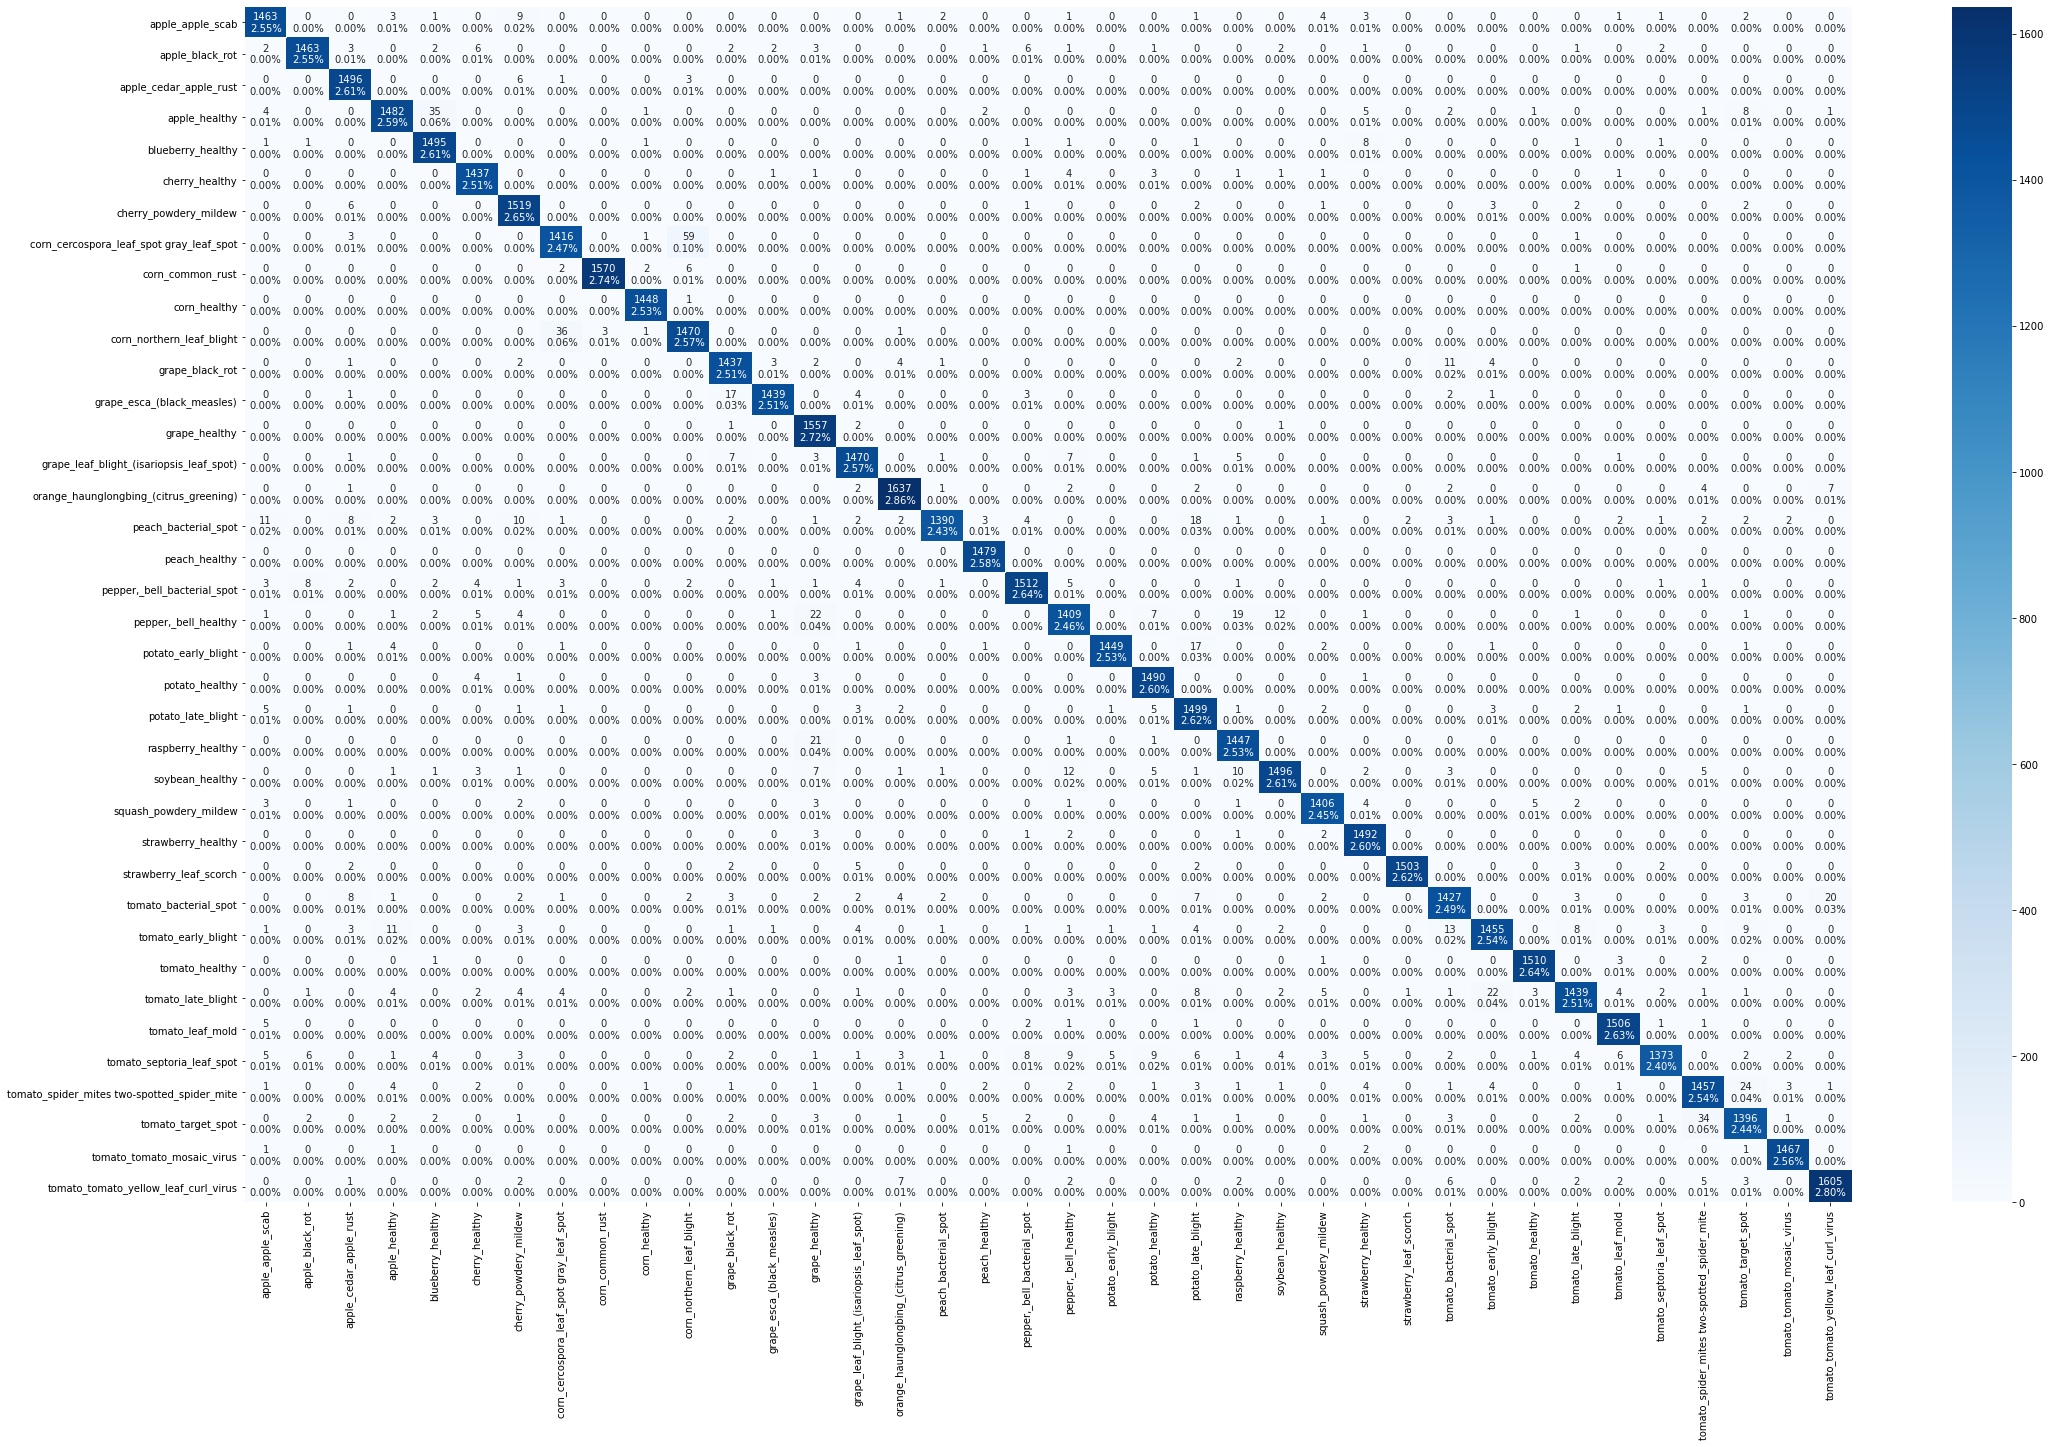

CPU times: user 30.4 s, sys: 7.11 s, total: 37.5 s
Wall time: 27.5 s
======   The model used is : etc   ========

CPU times: user 9min 54s, sys: 19.9 s, total: 10min 14s
Wall time: 4min 27s
======   The model used is : etc   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9771961059756384
Accuracy Score : 0.9687189065582069
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.96      0.97      0.96      1492
                            apple_black_rot       0.98      0.96      0.97      1498
                     apple_cedar_apple_rust       0.97      0.99      0.98      1506
                              apple_healthy       0.97      0.94      0.96      1542
                          blueberry_healthy       0.96      0.98      0.97      1511
                             cherry_healthy       0.97      0.98      0.97      1451
                      cherry_powdery_mildew       0.95      0.99 

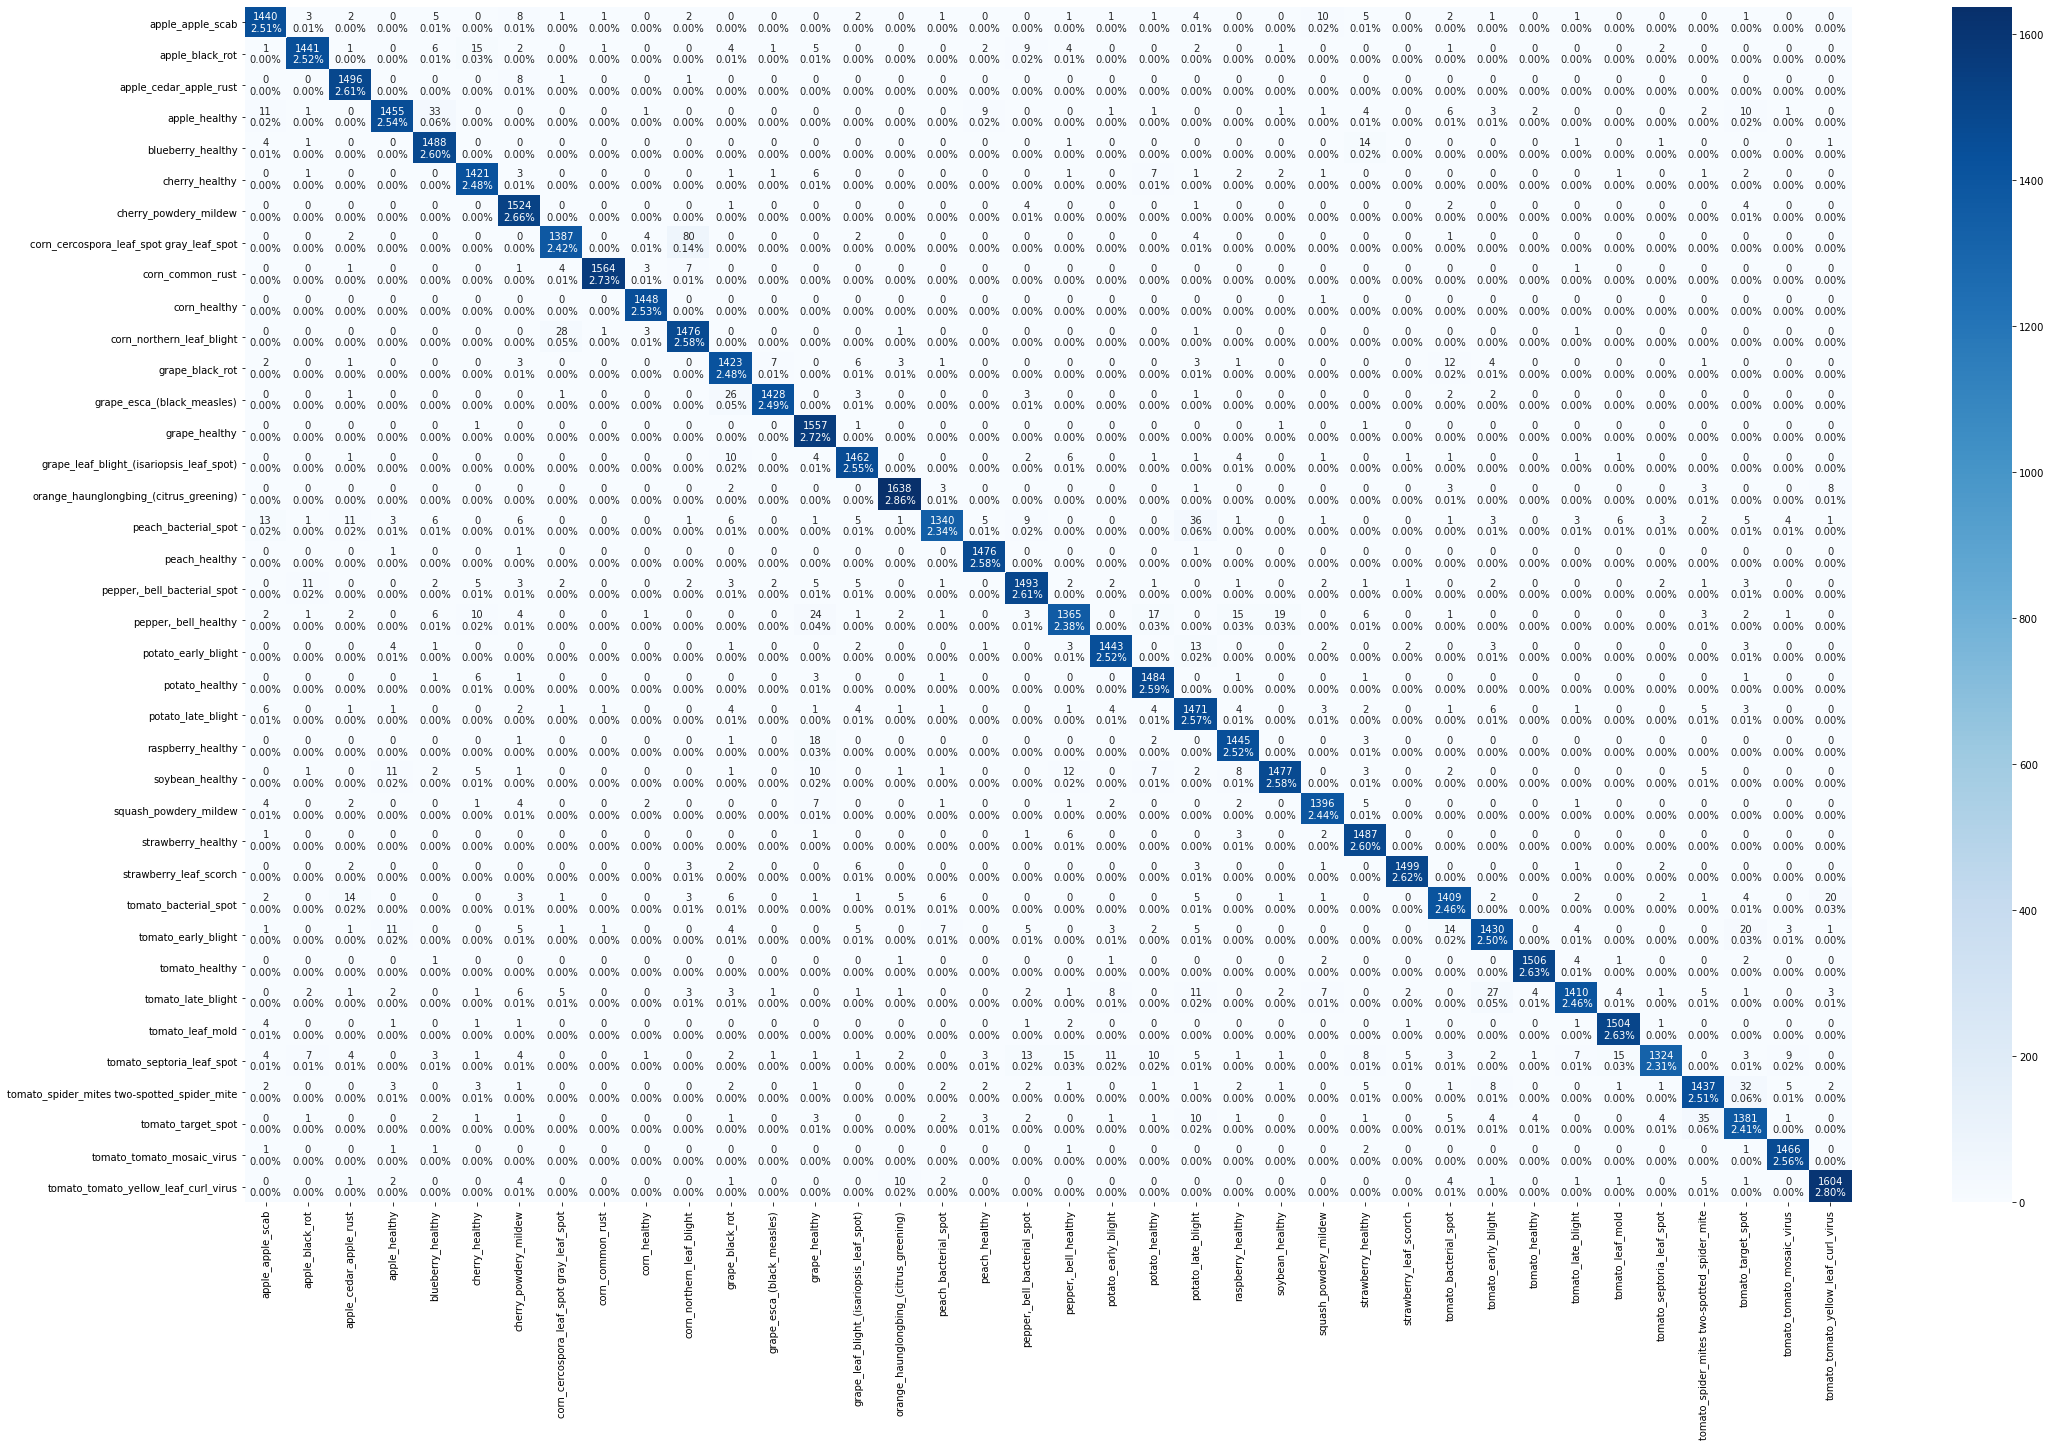

CPU times: user 37.7 s, sys: 15.8 s, total: 53.5 s
Wall time: 1min 22s
     SPEARMAN CORRELATION  Accuracy Score  F1 Score macro  F1 Score weighted
rfc             98.399102       97.763891       97.758486          97.760756
etc             97.719611       96.871891       96.853637          96.862287


In [10]:
for md_ in models.keys():
    %time model_target[md_] = fit_model(X_train, y_train, md_)
    %time prediction_hackathon( X_test, y_test, model_target[md_], md_)

print(df_accuracy)

#### SVM models

======   The model used is : svcp5   ========

CPU times: user 30min 12s, sys: 386 ms, total: 30min 13s
Wall time: 30min 13s
======   The model used is : svcp5   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.934928020288589
Accuracy Score : 0.9119695567929896
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.87      0.84      0.85      1492
                            apple_black_rot       0.85      0.88      0.87      1498
                     apple_cedar_apple_rust       0.91      0.96      0.93      1506
                              apple_healthy       0.92      0.90      0.91      1542
                          blueberry_healthy       0.92      0.96      0.94      1511
                             cherry_healthy       0.90      0.93      0.92      1451
                      cherry_powdery_mildew       0.95      0.94      0.94      1536
   corn_cercospora_leaf_spot gray_leaf_spot 

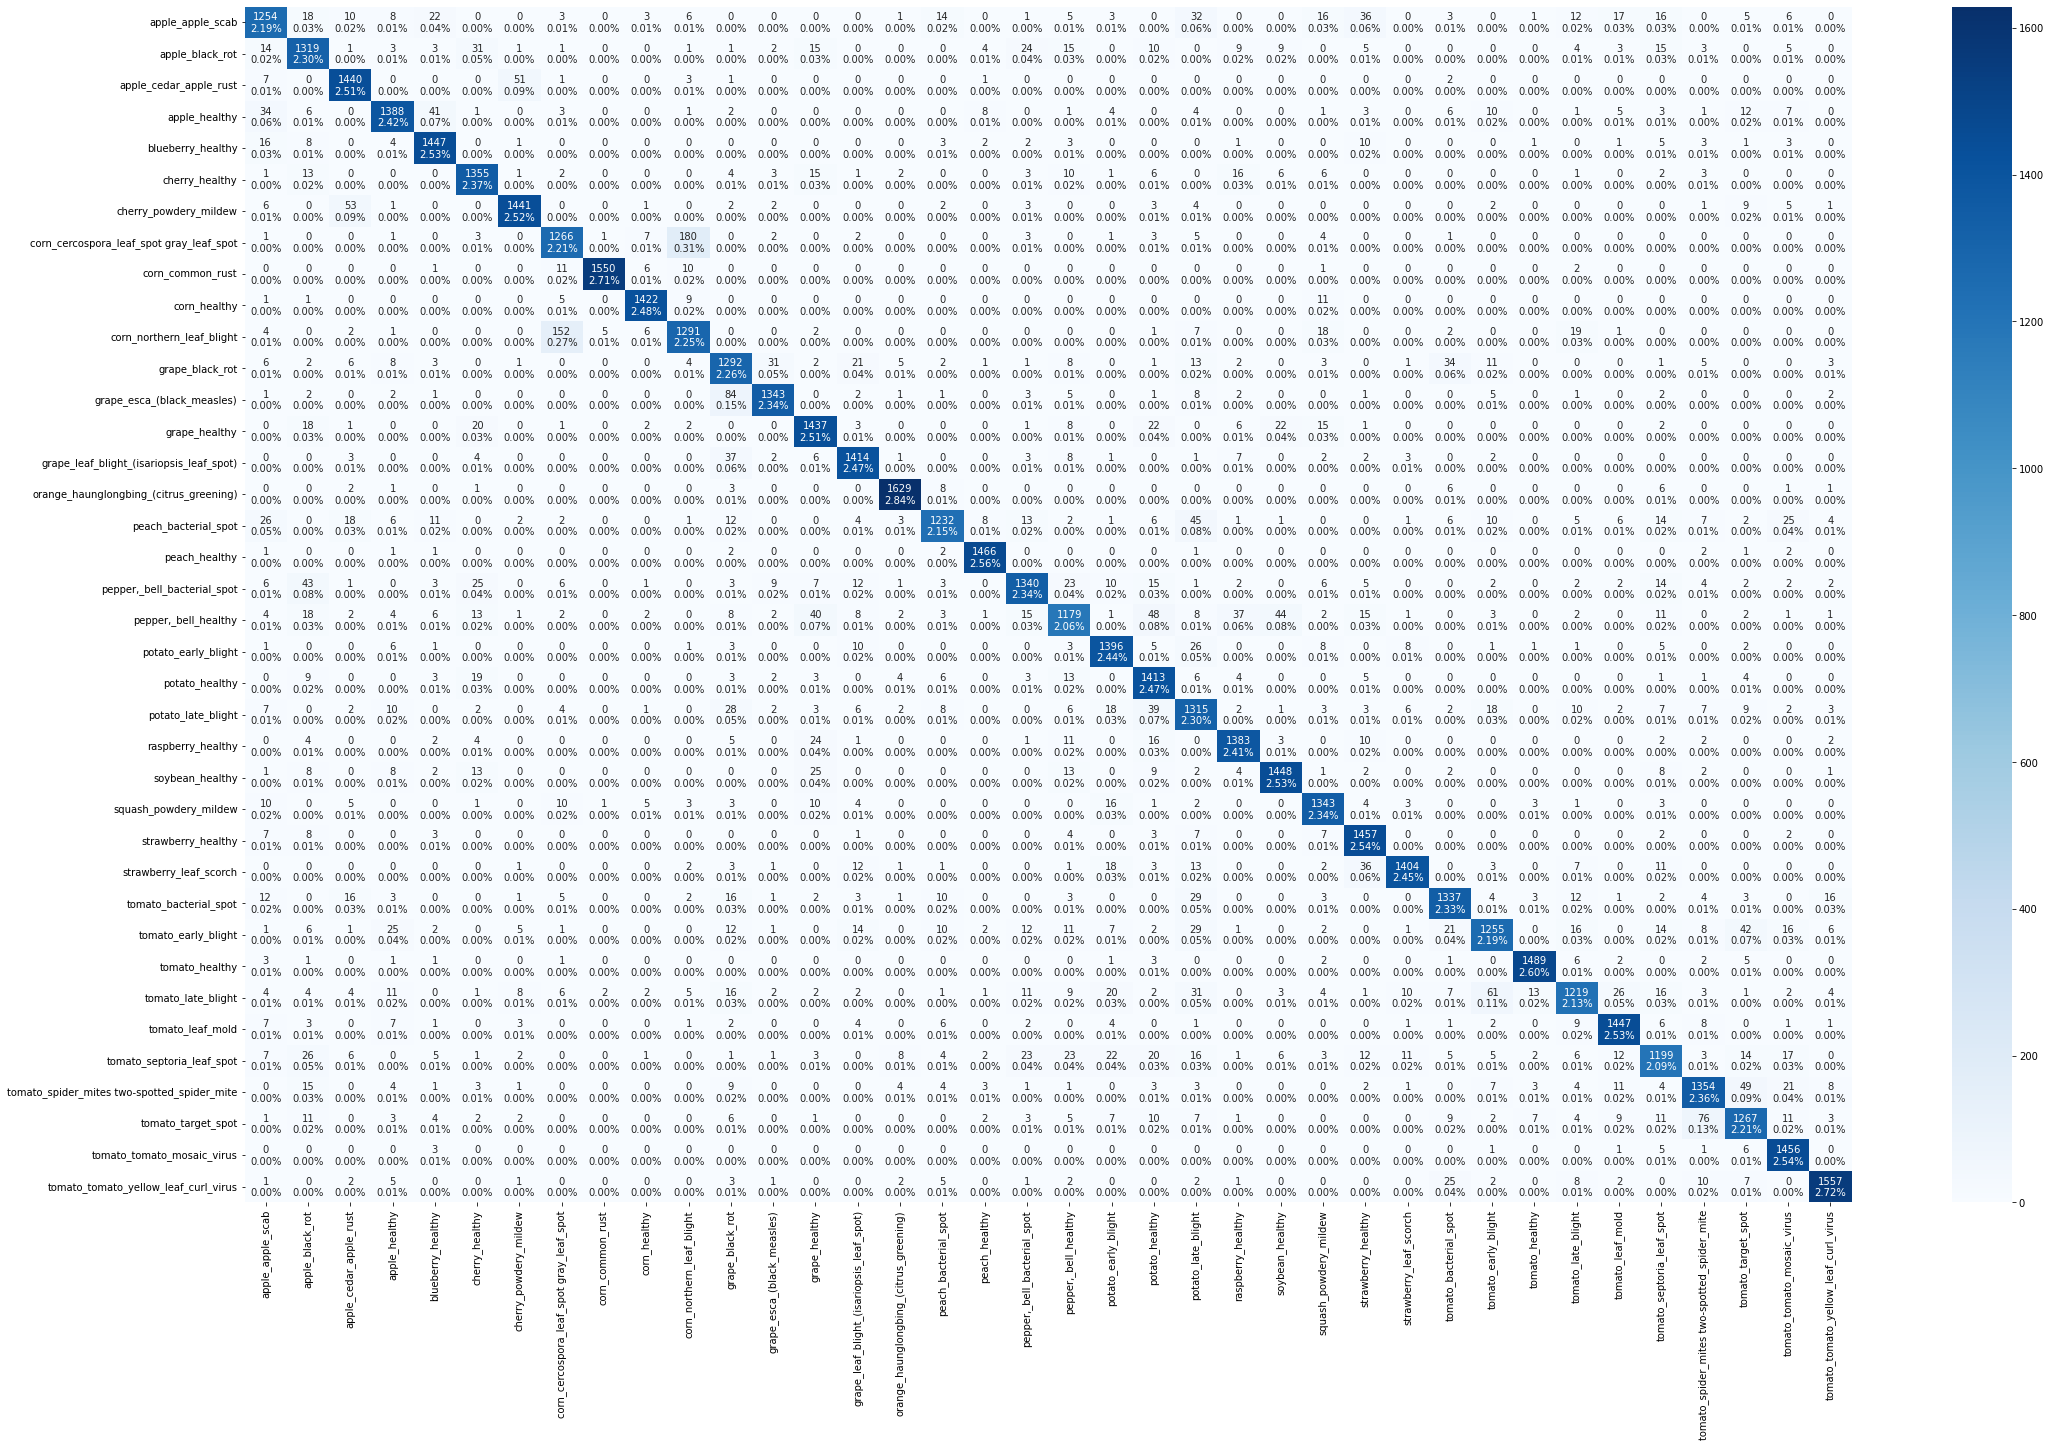

CPU times: user 38min 37s, sys: 494 ms, total: 38min 37s
Wall time: 38min 38s
======   The model used is : svcp6   ========

CPU times: user 28min 36s, sys: 355 ms, total: 28min 37s
Wall time: 28min 37s
======   The model used is : svcp6   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9398575568068831
Accuracy Score : 0.9185330005062231
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.88      0.85      0.86      1492
                            apple_black_rot       0.87      0.89      0.88      1498
                     apple_cedar_apple_rust       0.92      0.96      0.94      1506
                              apple_healthy       0.93      0.91      0.92      1542
                          blueberry_healthy       0.93      0.96      0.95      1511
                             cherry_healthy       0.91      0.93      0.92      1451
                      cherry_powdery_mildew       

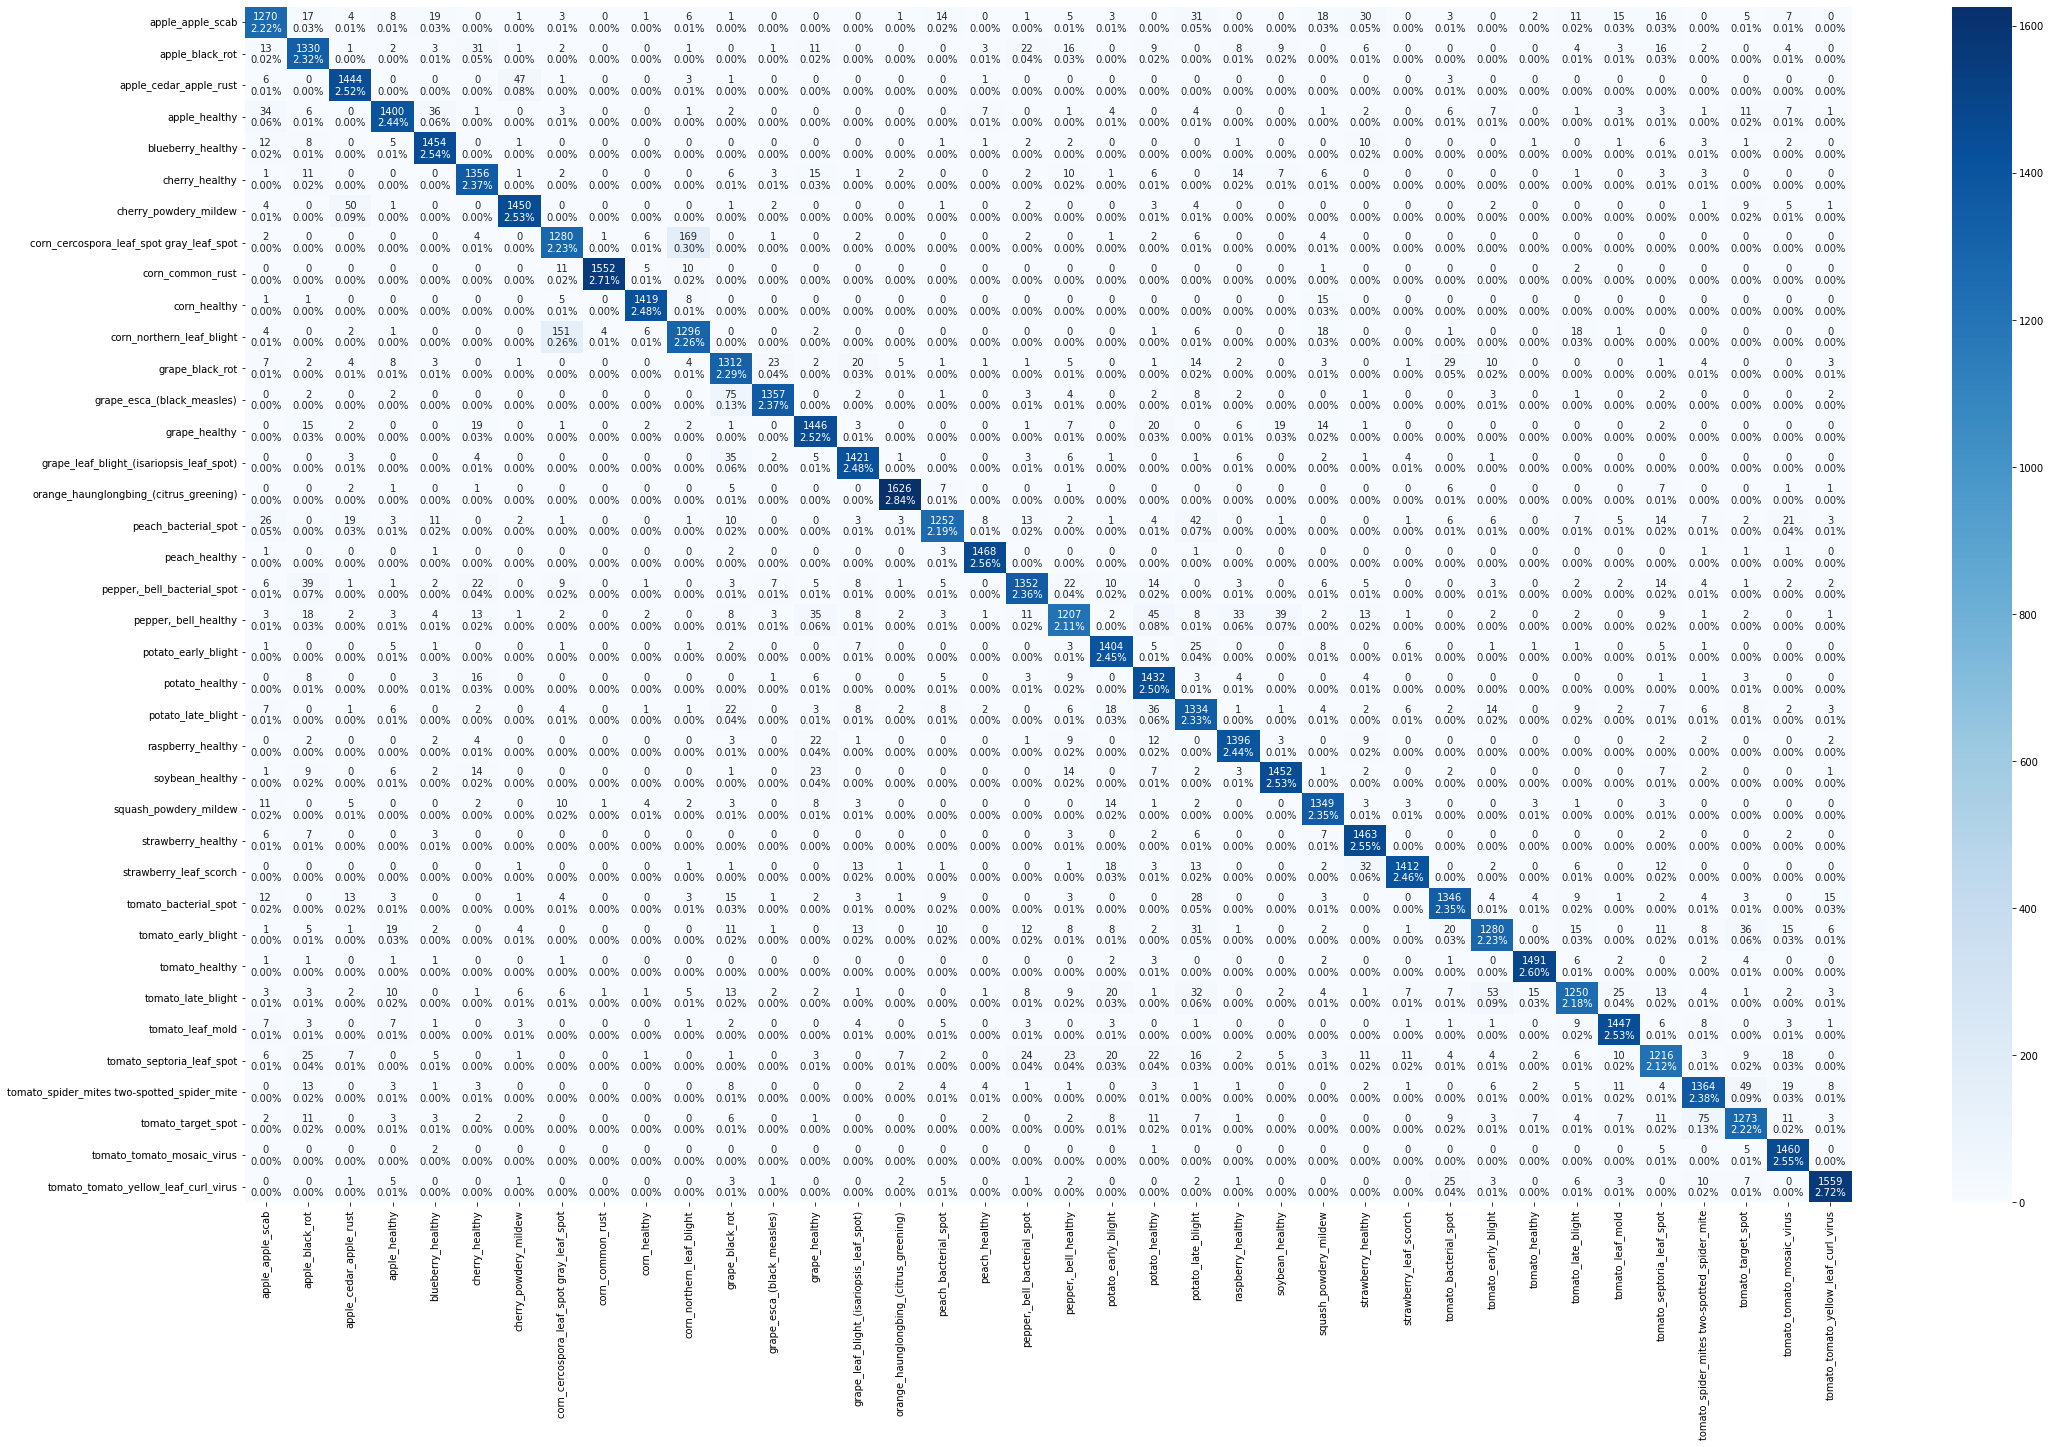

CPU times: user 36min 40s, sys: 425 ms, total: 36min 40s
Wall time: 36min 40s
======   The model used is : svcp7   ========

CPU times: user 27min 20s, sys: 381 ms, total: 27min 20s
Wall time: 27min 20s
======   The model used is : svcp7   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9448924980044614
Accuracy Score : 0.924345837624592
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.89      0.86      0.88      1492
                            apple_black_rot       0.88      0.90      0.89      1498
                     apple_cedar_apple_rust       0.93      0.96      0.95      1506
                              apple_healthy       0.94      0.92      0.93      1542
                          blueberry_healthy       0.93      0.96      0.95      1511
                             cherry_healthy       0.92      0.94      0.93      1451
                      cherry_powdery_mildew       0

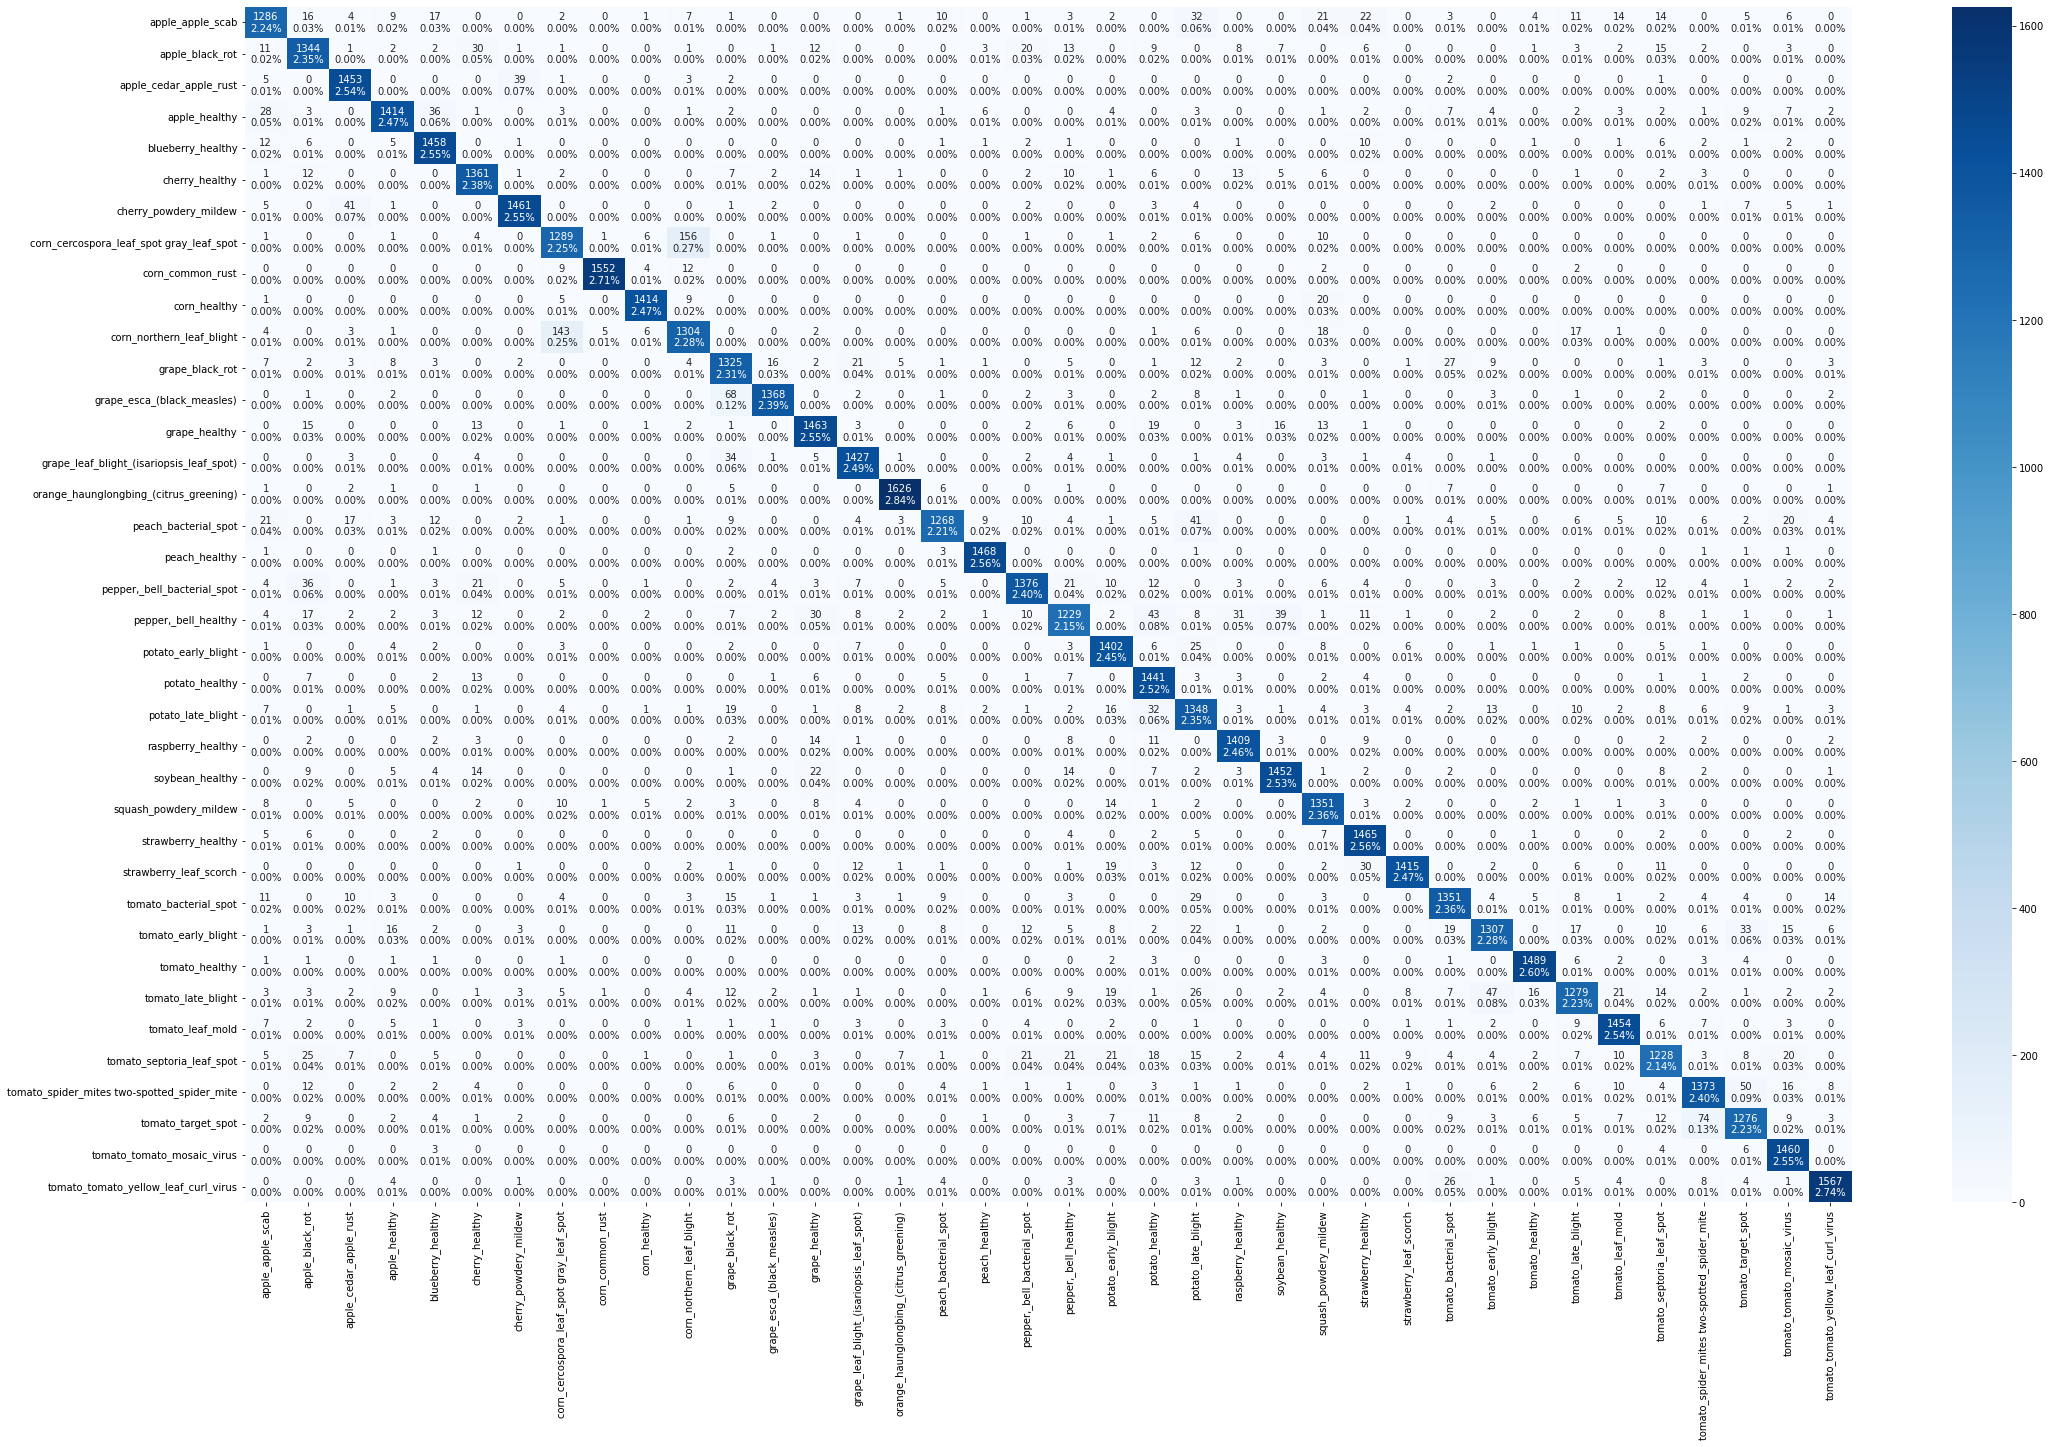

CPU times: user 36min 20s, sys: 395 ms, total: 36min 20s
Wall time: 36min 20s
======   The model used is : svcp8   ========

CPU times: user 26min 32s, sys: 385 ms, total: 26min 33s
Wall time: 26min 33s
======   The model used is : svcp8   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9477538493093076
Accuracy Score : 0.9279068549583676
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.89      0.87      0.88      1492
                            apple_black_rot       0.89      0.90      0.89      1498
                     apple_cedar_apple_rust       0.94      0.97      0.95      1506
                              apple_healthy       0.95      0.92      0.93      1542
                          blueberry_healthy       0.94      0.97      0.95      1511
                             cherry_healthy       0.92      0.94      0.93      1451
                      cherry_powdery_mildew       

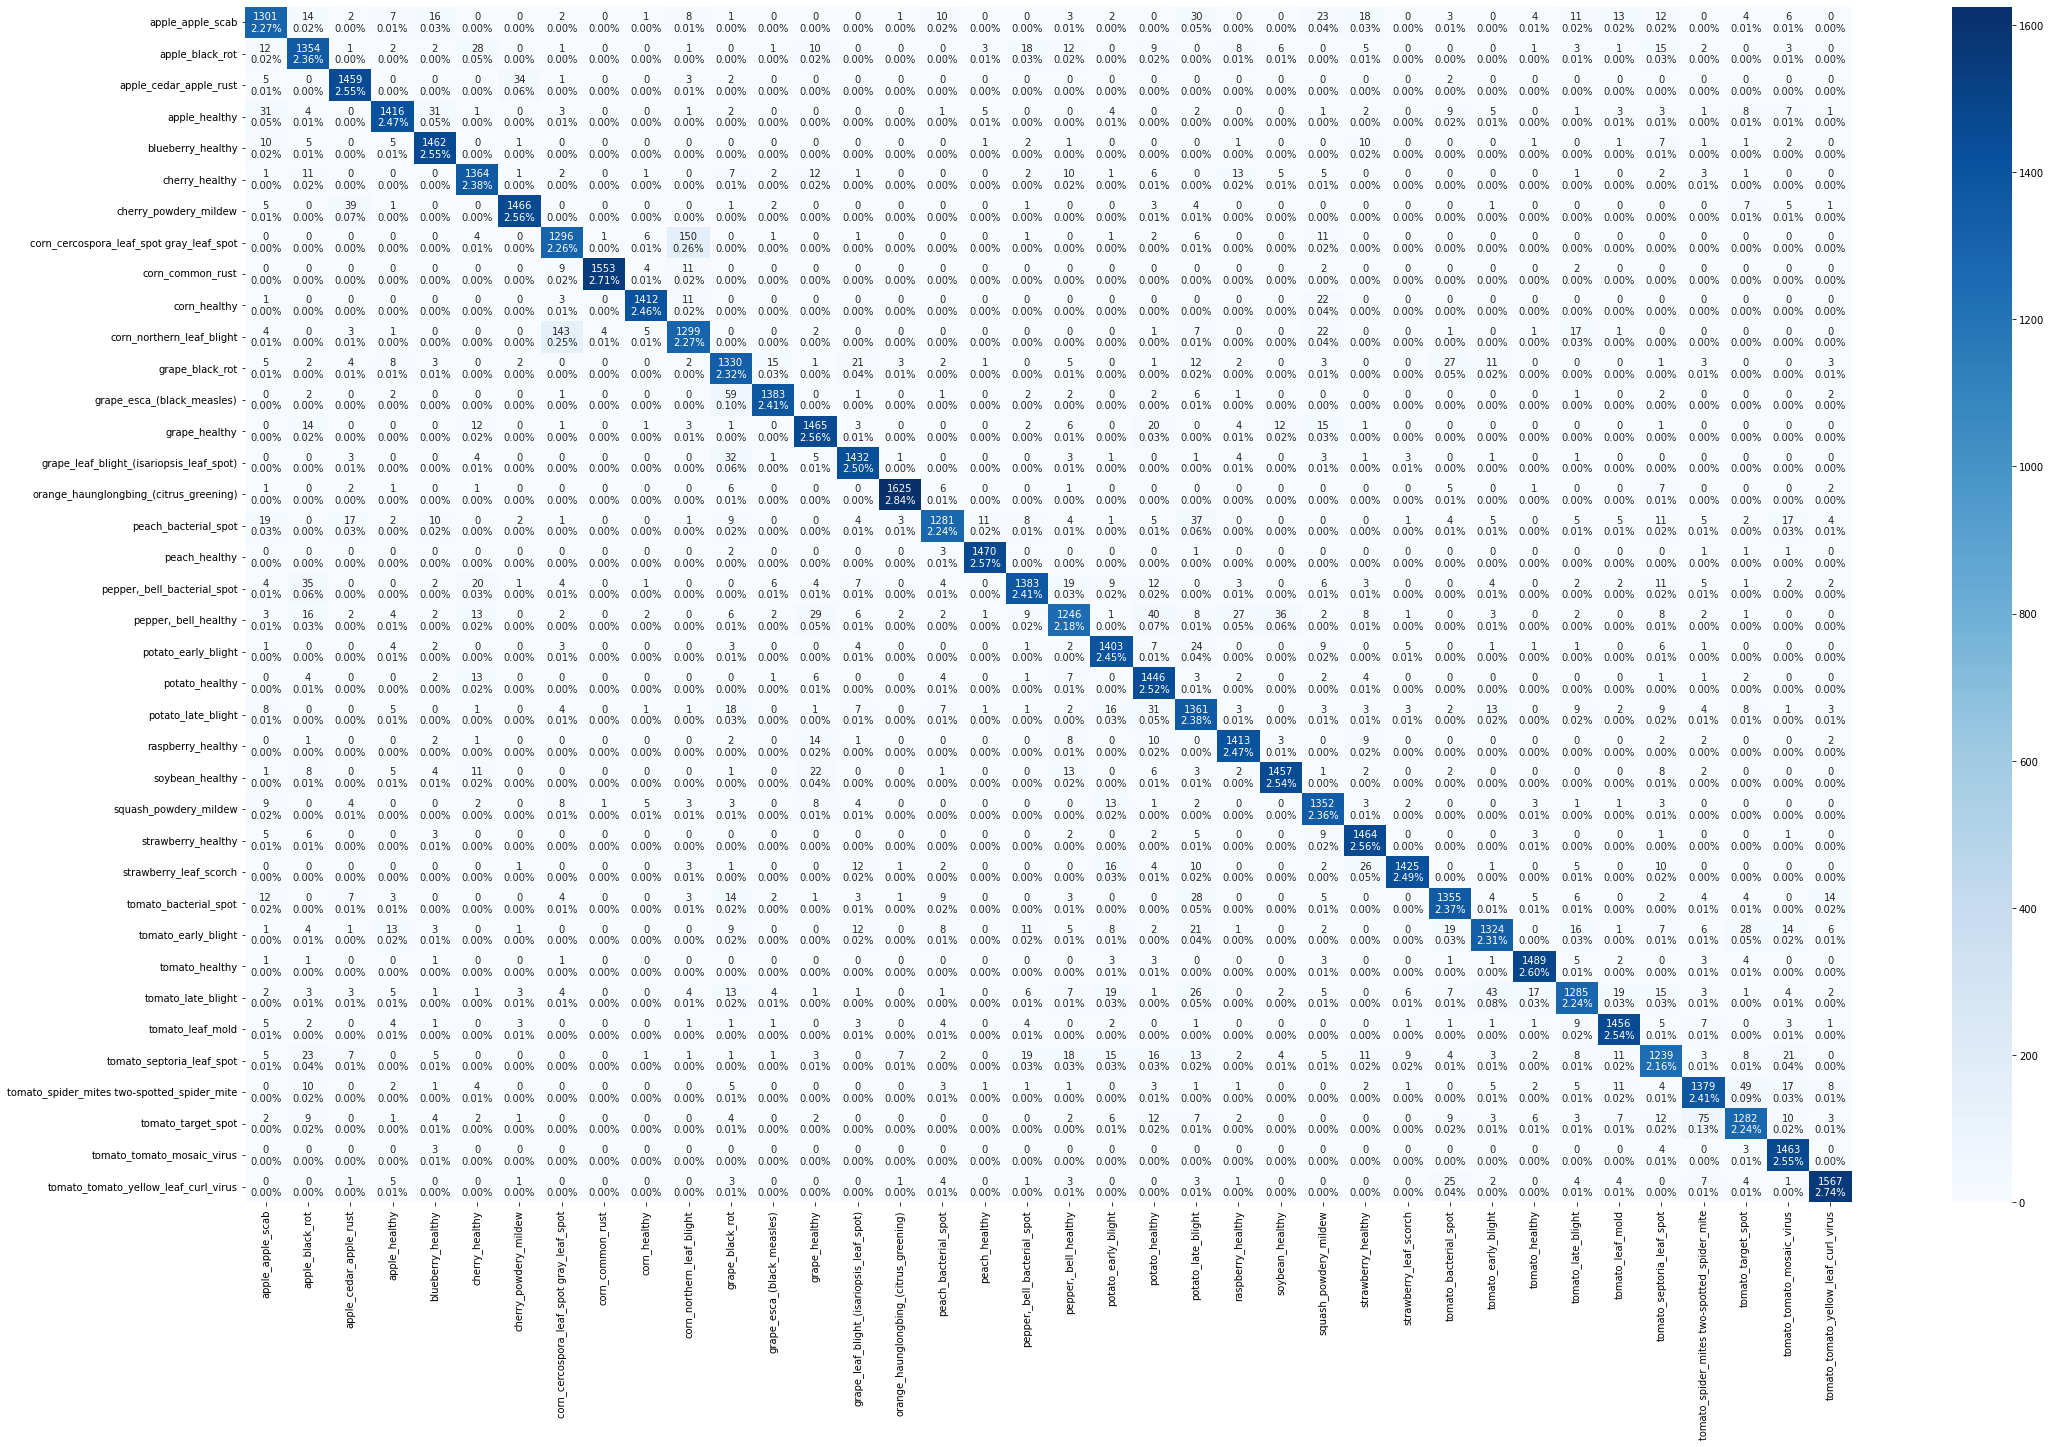

CPU times: user 32min 9s, sys: 384 ms, total: 32min 9s
Wall time: 32min 9s
======   The model used is : svcp9   ========

CPU times: user 24min 40s, sys: 345 ms, total: 24min 40s
Wall time: 24min 40s
======   The model used is : svcp9   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9497787358221542
Accuracy Score : 0.9306299858606665
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.89      0.88      0.89      1492
                            apple_black_rot       0.90      0.91      0.90      1498
                     apple_cedar_apple_rust       0.94      0.97      0.96      1506
                              apple_healthy       0.95      0.92      0.94      1542
                          blueberry_healthy       0.94      0.97      0.95      1511
                             cherry_healthy       0.92      0.95      0.93      1451
                      cherry_powdery_mildew       0.9

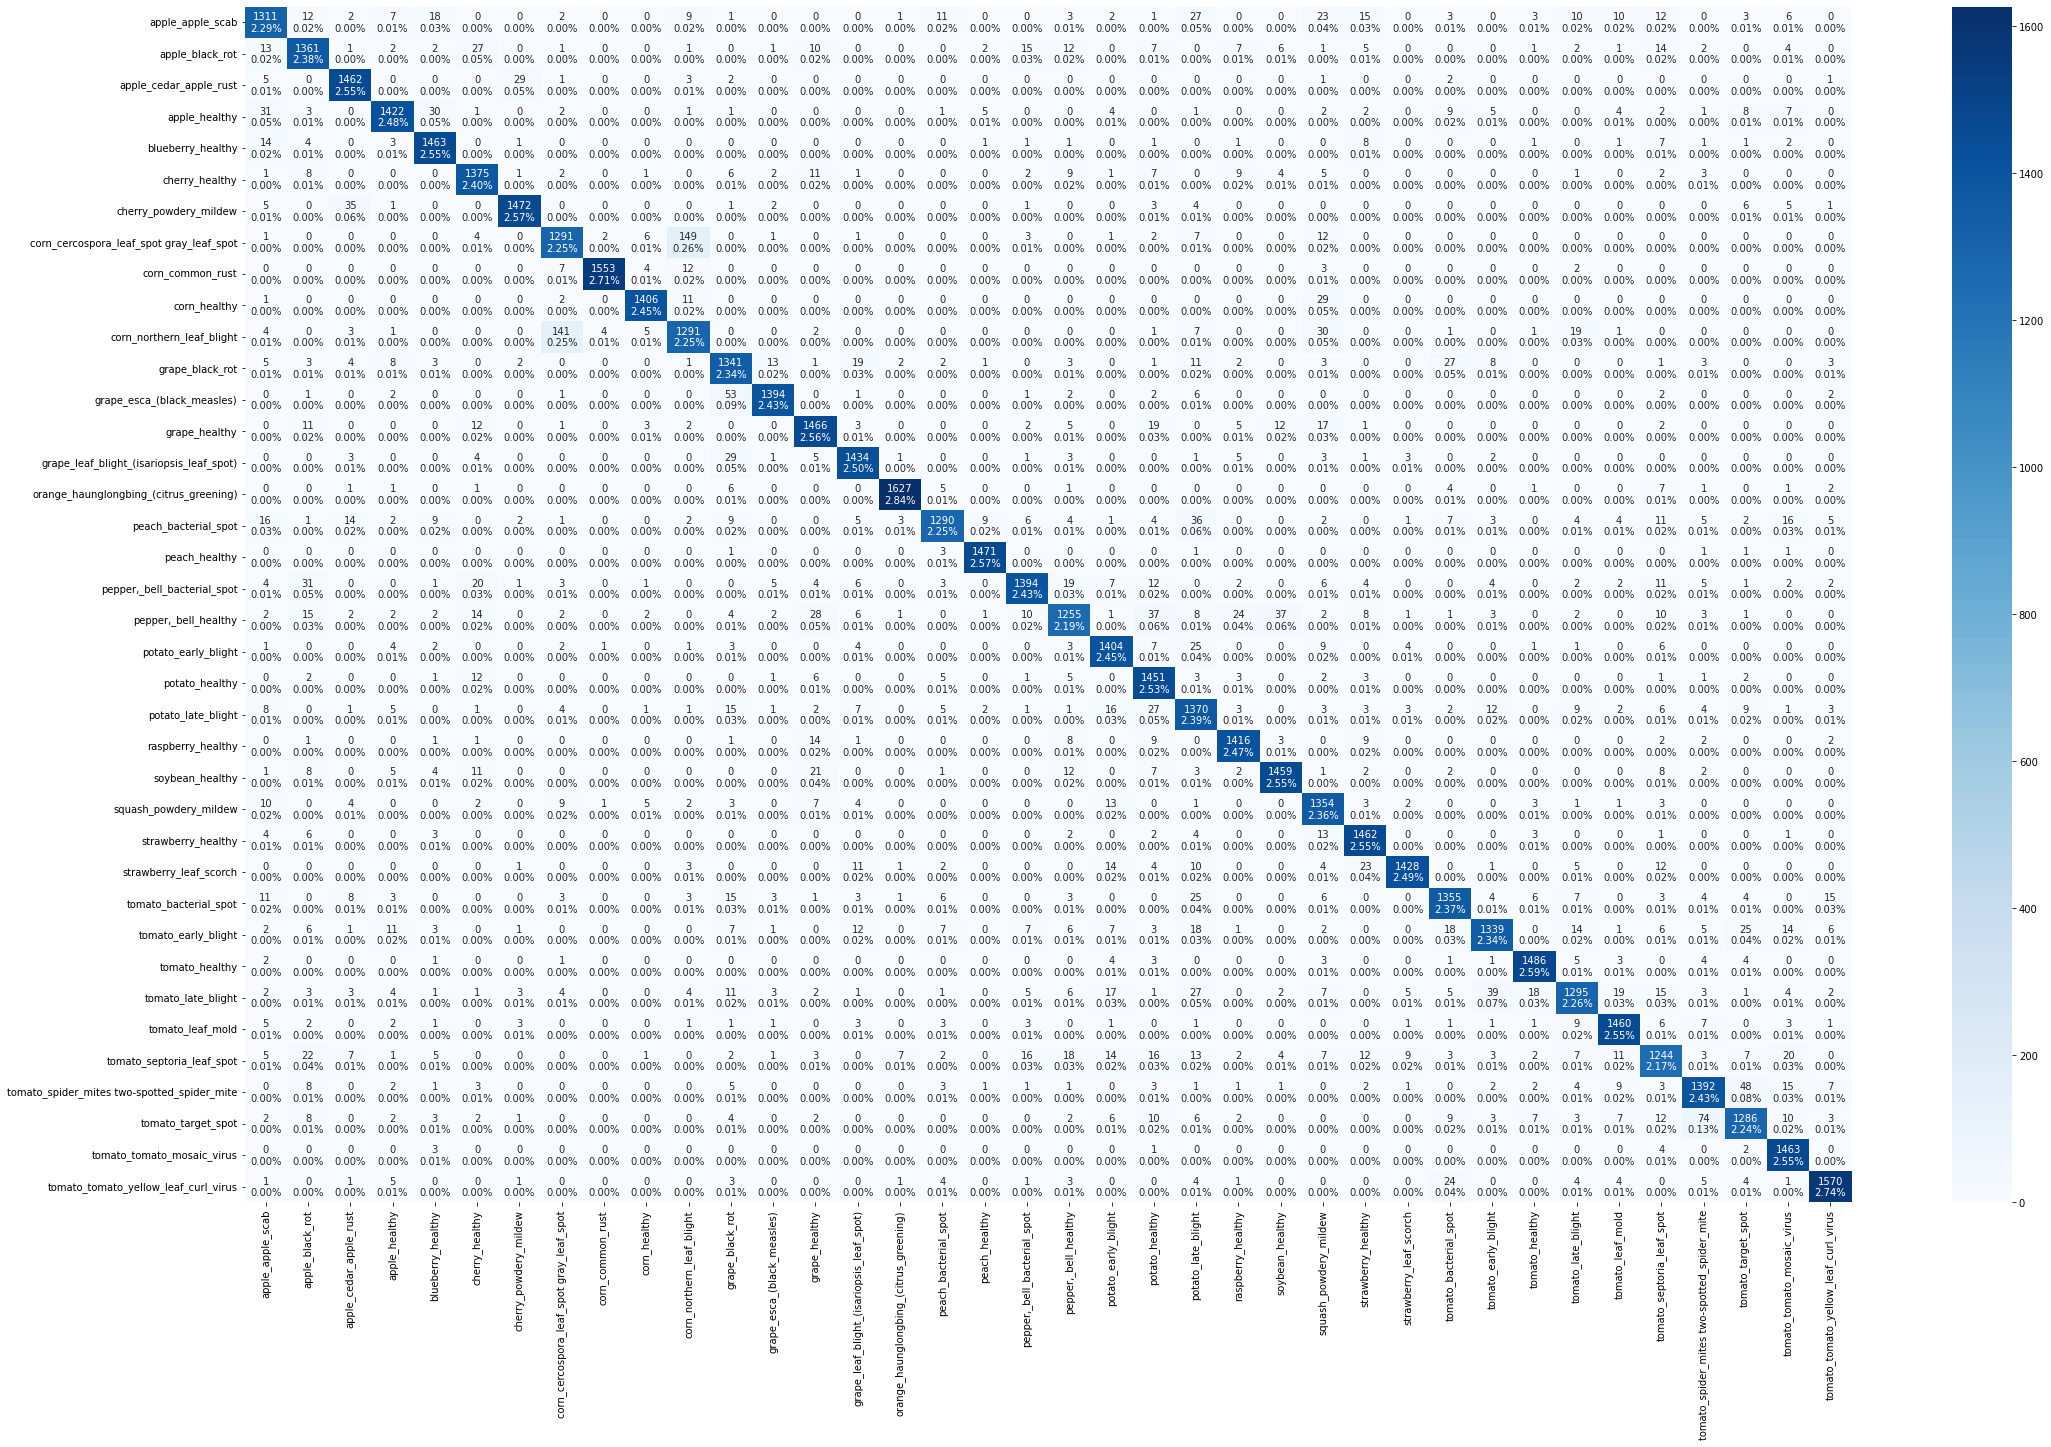

CPU times: user 30min 59s, sys: 443 ms, total: 30min 59s
Wall time: 30min 59s
======   The model used is : svcp10   ========

CPU times: user 24min 46s, sys: 358 ms, total: 24min 47s
Wall time: 24min 47s
======   The model used is : svcp10   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9518404626070955
Accuracy Score : 0.9323930385602318
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.90      0.88      0.89      1492
                            apple_black_rot       0.90      0.91      0.91      1498
                     apple_cedar_apple_rust       0.95      0.97      0.96      1506
                              apple_healthy       0.96      0.92      0.94      1542
                          blueberry_healthy       0.95      0.97      0.96      1511
                             cherry_healthy       0.92      0.95      0.94      1451
                      cherry_powdery_mildew     

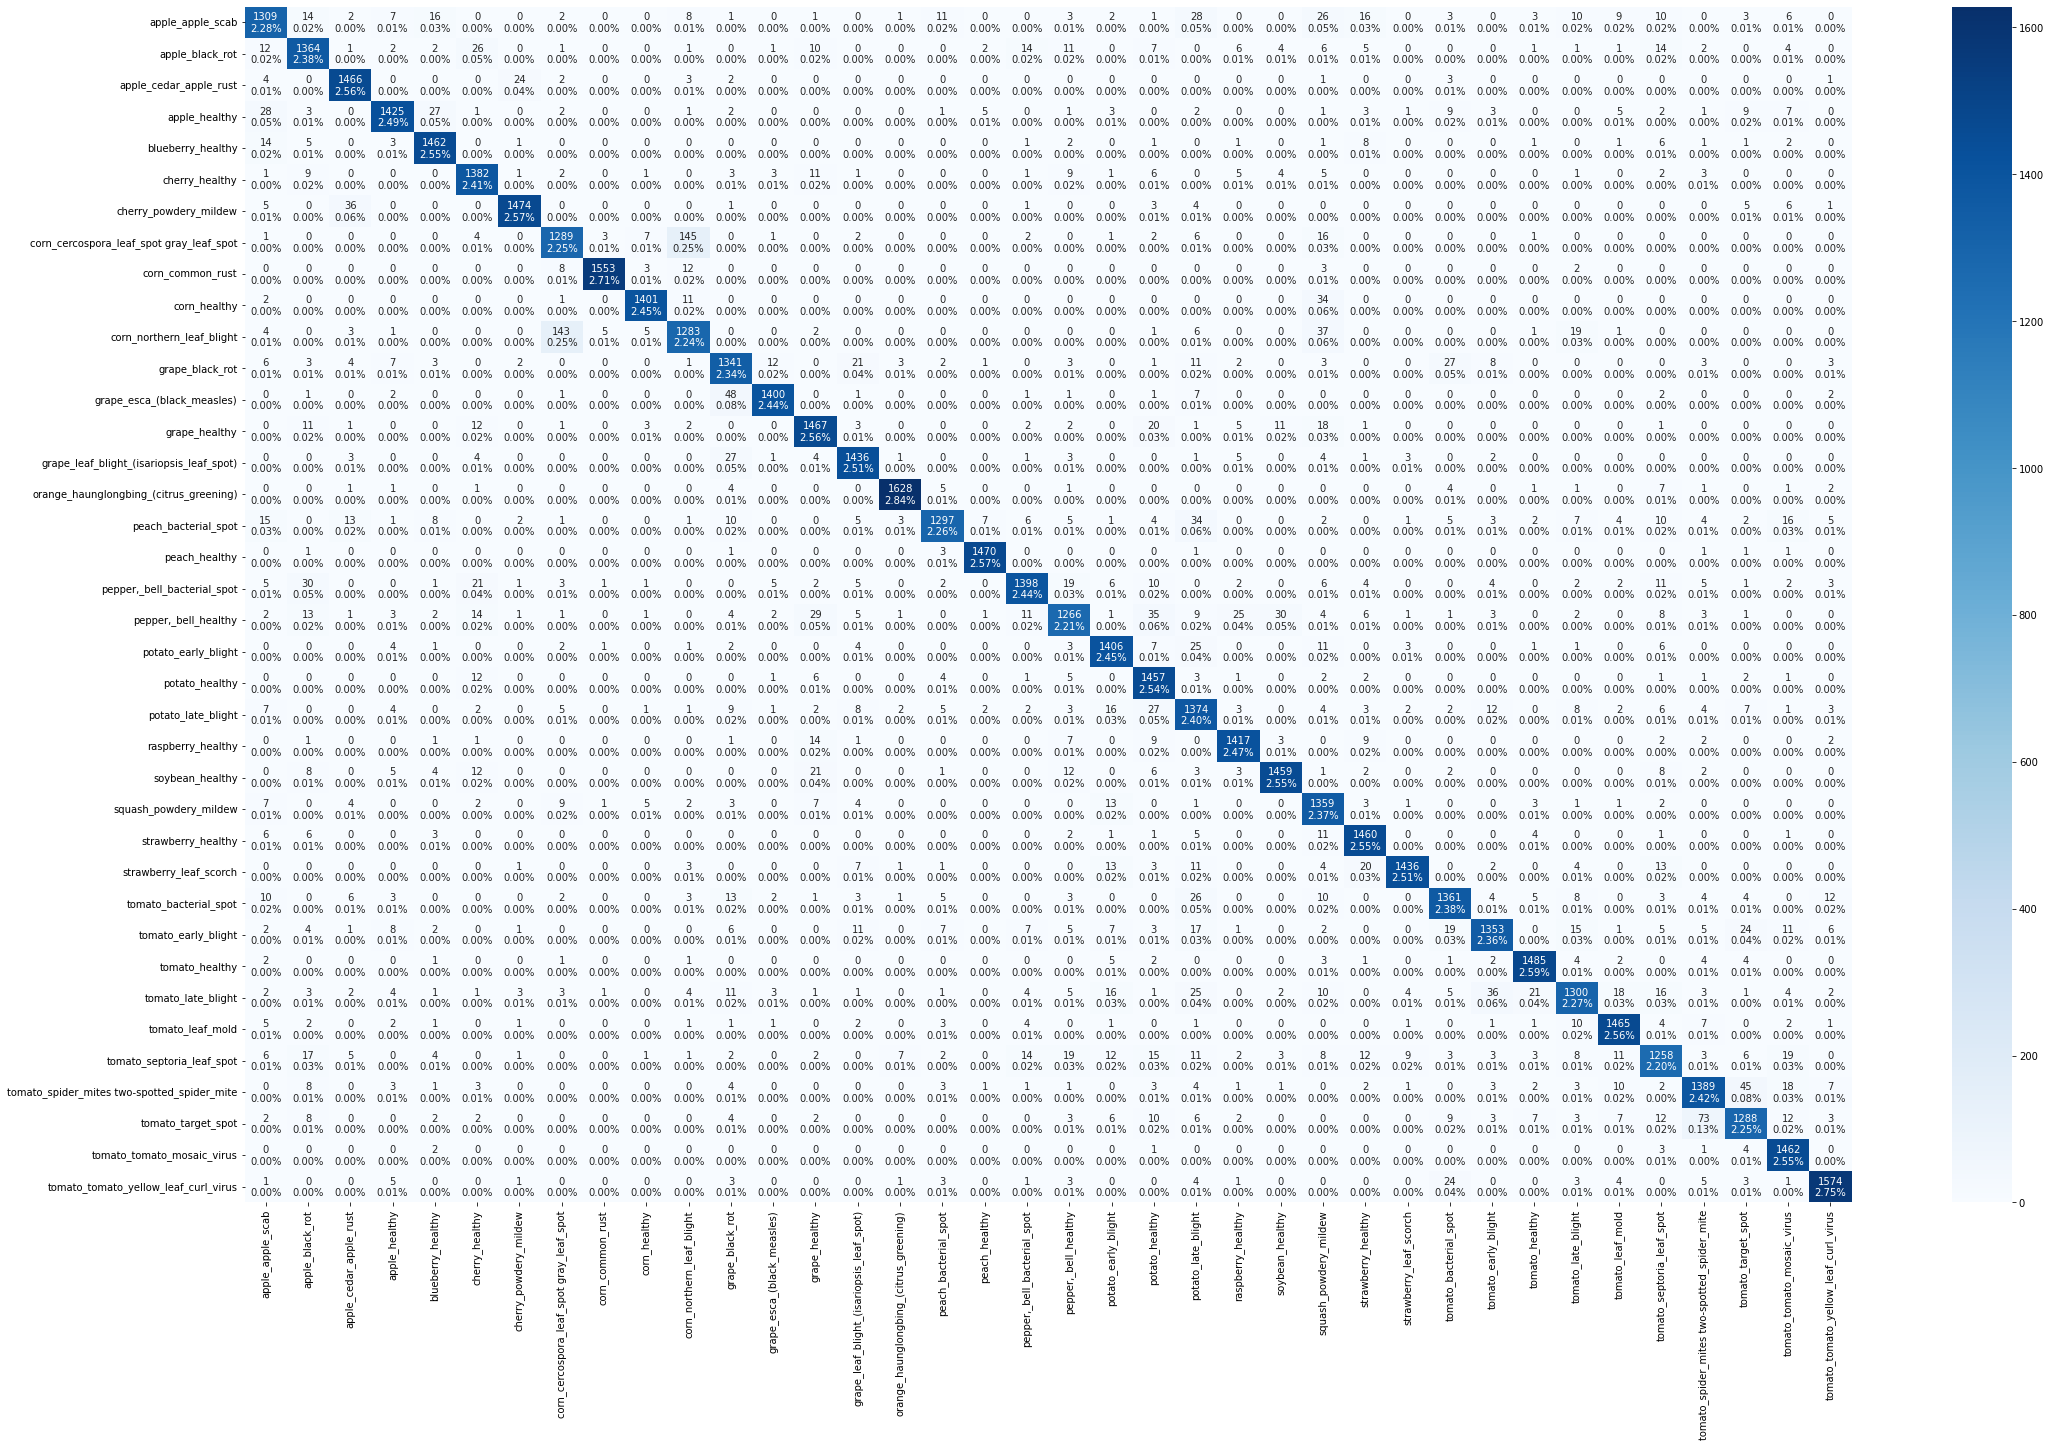

CPU times: user 30min, sys: 424 ms, total: 30min
Wall time: 30min
======   The model used is : svcp11   ========

CPU times: user 24min 28s, sys: 337 ms, total: 24min 28s
Wall time: 24min 28s
======   The model used is : svcp11   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9519759128924169
Accuracy Score : 0.9328992616125823
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.90      0.88      0.89      1492
                            apple_black_rot       0.91      0.91      0.91      1498
                     apple_cedar_apple_rust       0.95      0.97      0.96      1506
                              apple_healthy       0.96      0.93      0.94      1542
                          blueberry_healthy       0.95      0.97      0.96      1511
                             cherry_healthy       0.92      0.96      0.94      1451
                      cherry_powdery_mildew       0.98      

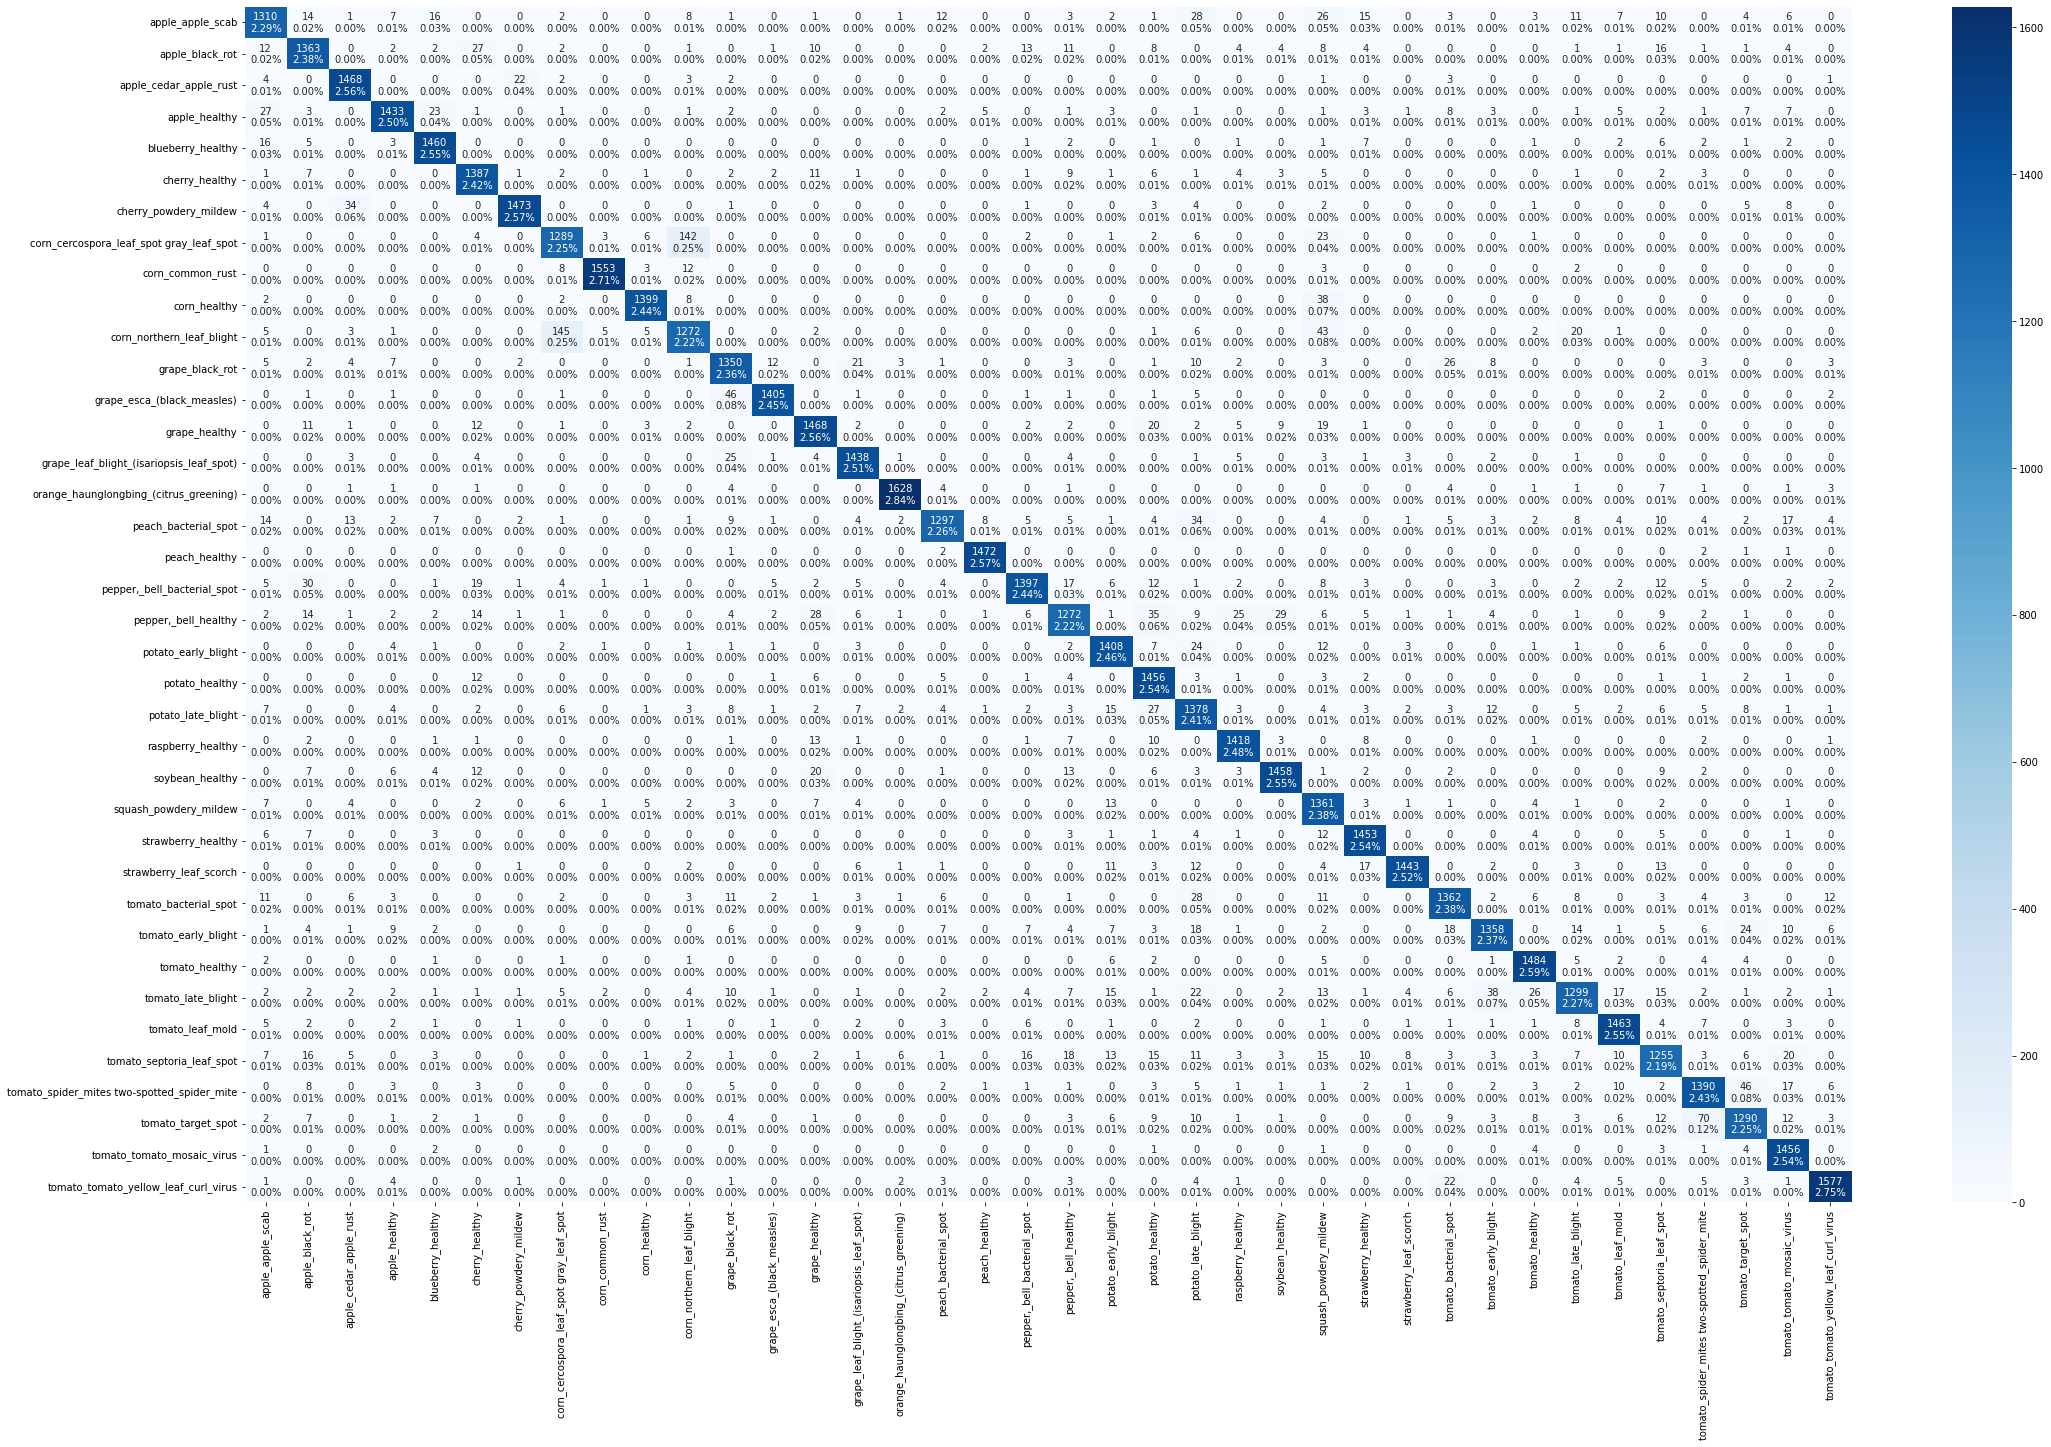

CPU times: user 29min 41s, sys: 384 ms, total: 29min 41s
Wall time: 29min 41s
======   The model used is : svcp12   ========

CPU times: user 24min 33s, sys: 336 ms, total: 24min 33s
Wall time: 24min 33s
======   The model used is : svcp12   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9514072398073642
Accuracy Score : 0.9334229406322552
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.90      0.88      0.89      1492
                            apple_black_rot       0.91      0.91      0.91      1498
                     apple_cedar_apple_rust       0.95      0.98      0.96      1506
                              apple_healthy       0.96      0.93      0.95      1542
                          blueberry_healthy       0.96      0.97      0.96      1511
                             cherry_healthy       0.93      0.96      0.94      1451
                      cherry_powdery_mildew     

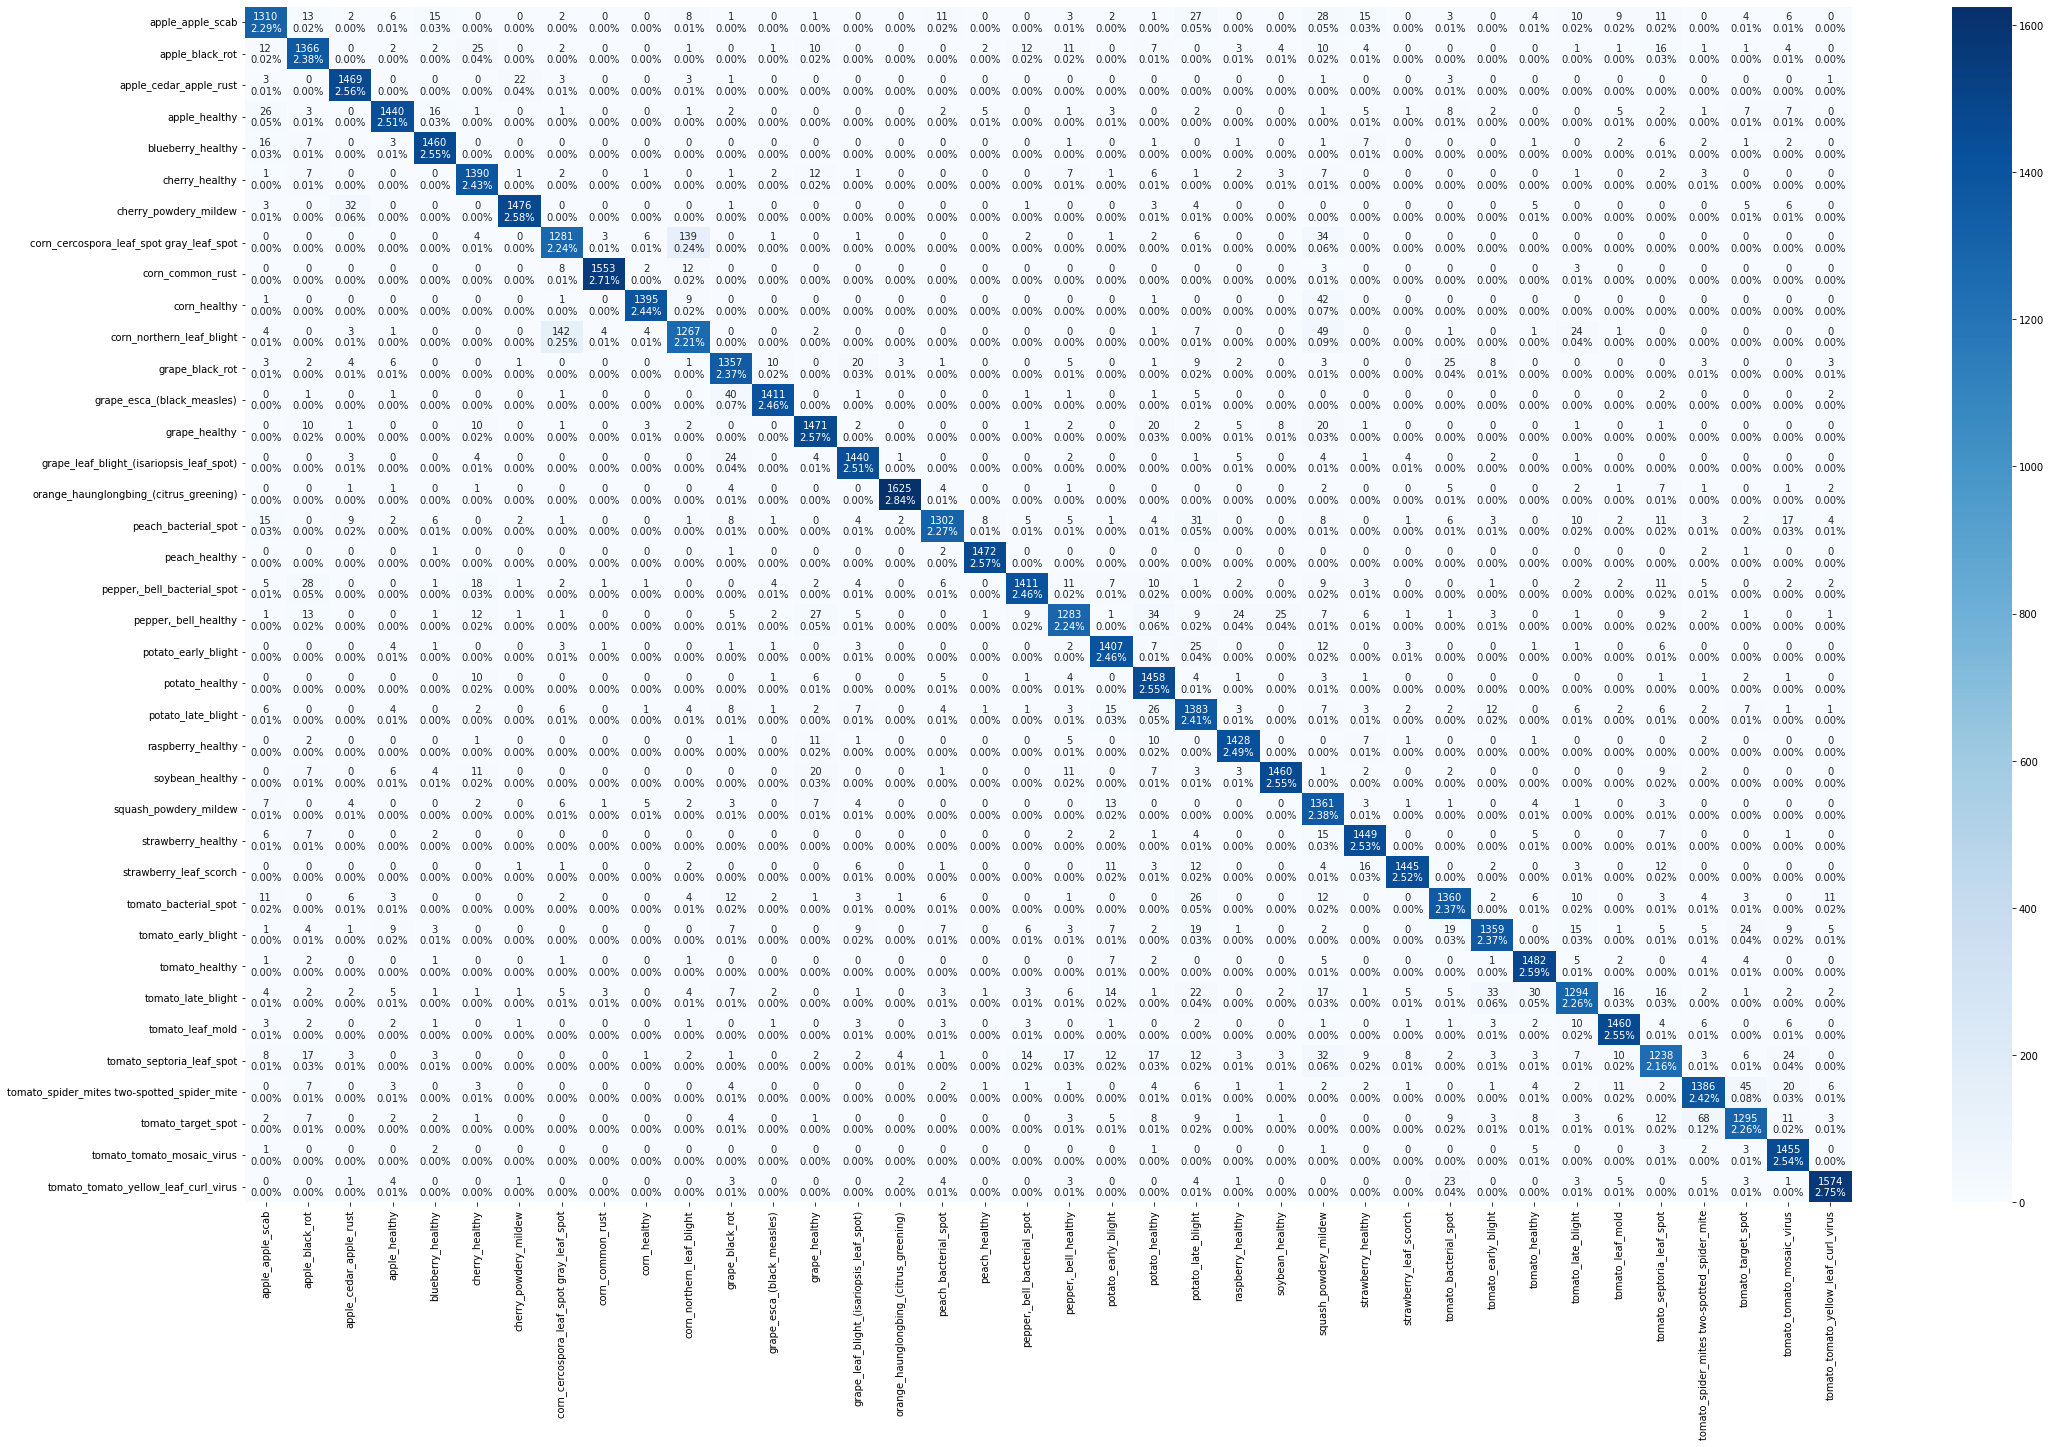

CPU times: user 29min 3s, sys: 414 ms, total: 29min 4s
Wall time: 29min 4s
        SPEARMAN CORRELATION  Accuracy Score  F1 Score macro  \
xgc                99.364406       98.964861       98.963004   
rfc                98.461464       97.840697       97.833602   
etc                97.779412       96.962662       96.945723   
svcp5              93.492802       91.196956       91.127393   
svcp6              93.985756       91.853300       91.794288   
svcp7              94.489250       92.434584       92.380977   
svcp8              94.775385       92.790685       92.740233   
svcp9              94.977874       93.062999       93.013979   
svcp10             95.184046       93.239304       93.193439   
svcp11             95.197591       93.289926       93.246312   
svcp12             95.140724       93.342294       93.302177   

        F1 Score weighted  
xgc             98.964754  
rfc             97.837393  
etc             96.953748  
svcp5           91.165480  
svcp6           

In [11]:
for degree in range(5,13):
    svcp = SVC(kernel='poly', degree=degree, random_state=42) # Polynomial Kernel
    models = dict([(f'svcp{degree}', svcp)])
    for md_ in models.keys():
        %time model_target[md_] = fit_model(X_train, y_train, md_)
        %time prediction_hackathon( X_test, y_test, model_target[md_], md_)

print(df_accuracy)

In [12]:
# Stop execution before submission !!!
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/home/dev/.pyenv/versions/3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##### SVM model

In [ ]:
%%time
from sklearn.svm import SVC

svcg = SVC(kernel='rbf', probability=True, random_state=42) # Gaussien Kernel
svcp3 = SVC(kernel='poly', degree=3, probability=True, random_state=42) # Polynomial Kernel

models = dict([('svcp3', svcp3)])

for kernel in ['rbf', 'sigmoid', 'poly', 'linear', 'precomputed']:
  svcp = SVC(kernel=kernel, degree=6, random_state=42) # Polynomial Kernel
  models = dict([(f'svcp{kernel}', svcp)])
  for md in models.keys():
    %time model_target[md] = prediction_hackathon(X_train, X_test, y_train, y_test, md)

display(df_accuracy)

In [ ]:
svcp = SVC(kernel='poly', degree=6, random_state=42, cache_size=1000) # Polynomial Kernel
models = dict([('svcpCS', svcp)])
for md in models.keys():
  %time model_target[md] = prediction_hackathon(X_train, X_test, y_train, y_test, md)

display(df_accuracy)

======   The model used is : xgc500   ========

CPU times: user 1d 7h 15min 37s, sys: 10.8 s, total: 1d 7h 15min 48s
Wall time: 39min 10s
======   The model used is : xgc500   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9929258950838431
Accuracy Score : 0.9889678286522248
                                             precision    recall  f1-score   support

                           apple_apple_scab       0.99      0.99      0.99      1492
                            apple_black_rot       0.99      0.99      0.99      1498
                     apple_cedar_apple_rust       0.99      0.99      0.99      1506
                              apple_healthy       0.99      0.99      0.99      1542
                          blueberry_healthy       0.99      0.99      0.99      1511
                             cherry_healthy       0.99      0.99      0.99      1451
                      cherry_powdery_mildew       0.99      0.99      0.99      1536
   corn_cercospora_leaf_spot 

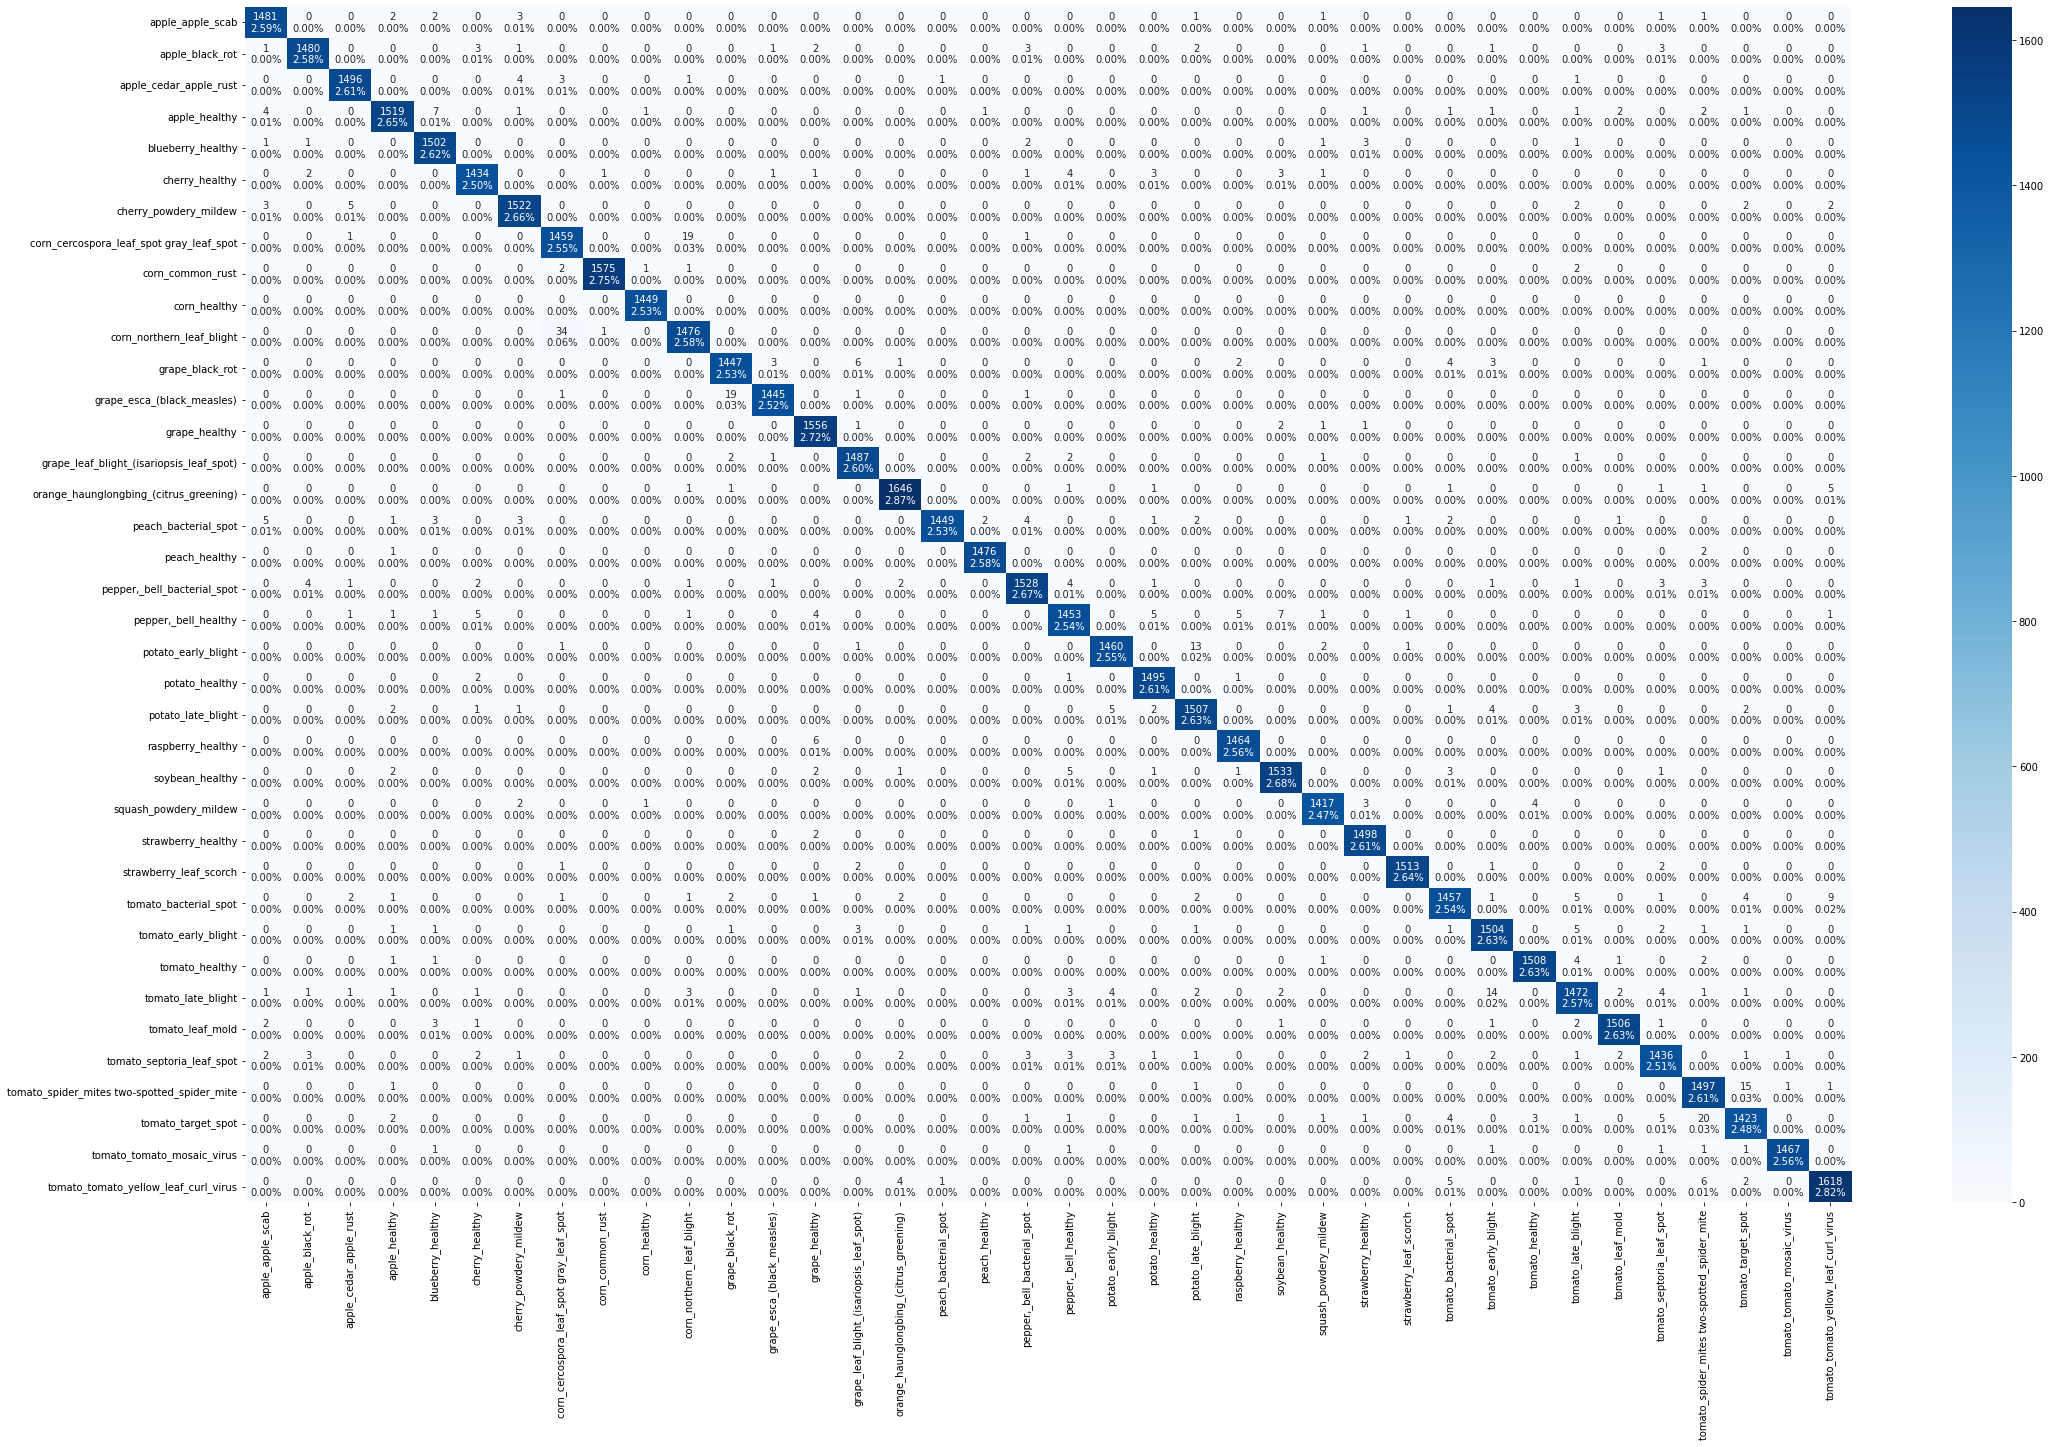

CPU times: user 32.7 s, sys: 388 ms, total: 33.1 s
Wall time: 5.73 s
            SPEARMAN CORRELATION  Accuracy Score  F1 Score macro  \
best_model             99.382337       98.964861       98.963186   
xgc500                 99.292590       98.896783       98.895086   

            F1 Score weighted  
best_model          98.964845  
xgc500              98.896682  
CPU times: user 1d 7h 16min 10s, sys: 11.1 s, total: 1d 7h 16min 21s
Wall time: 39min 15s


In [17]:
%%time
# xgb.set_config(verbosity=3)
xgc500 = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax', eval_metric='mlogloss', n_estimators=500, n_jobs=-1)

models = dict([('xgc500', xgc500)])

for md_ in models.keys():
    %time model_target[md_] = fit_model(X_train, y_train, md_)
    %time prediction_hackathon( X_test, y_test, model_target[md_], md_)

print(df_accuracy)

In [ ]:
# Stop execution before submission !!!
raise SystemExit("Stop right there!")

### Find the SVM Classifier optimal hyperparameters

In [ ]:
# Finding optimal parameters

svc = SVC(random_state=42)

parameters = {
              'C': [.5,.7,1,1.2,1.5,2],
              'gamma': ['scale'],
              'kernel': ['poly'],
              'degree': [6],              
            }

grid = GridSearchCV(estimator  = svc, scoring="f1", refit=True, 
                          param_grid = parameters, 
                          cv = 5, verbose = 10, 
                          n_jobs = -1)

# grid = RandomizedSearchCV(estimator  = etc, scoring="f1_weighted",
#                           param_distributions = parameters, 
#                           n_iter = 500, cv = 3, verbose = 2, 
#                           random_state = 42, n_jobs = -1)

grid.fit(X_train, y_train)

# Dictionary of best parameters
best_pars = grid.best_params_
print(best_pars)

# Best ETC model that was found based on the metric score you specify
best_model = grid.best_estimator_

# # Save model
# pickle.dump(grid.best_estimator_, open("xgb_log_reg.pickle", "wb"))

models = dict([('best_model', best_model)])

for md in models.keys():
  %time model_target[md] = prediction_hackathon(X_train, X_test, y_train, y_test, md)

print(df_accuracy)

### Find the XGBoost optimal hyperparameters
[Paramètres XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method)

In [11]:
# Finding optimal parameters

xgc = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax', n_estimators=500, eval_metric='mlogloss', n_jobs=-1)

parameters = {
     # "booster"          : ["gbtree", "gblinear", "dart"],
     "eta"              : [0.001, 0.01, 0.1, 0.30, 0.4] ,
     # "max_depth"        : [ 3, 4, 5, 6],
     # "min_child_weight" : [ 1, 5, 7],
     "gamma"            : [ 0, 0.1, 0.3, 0.5, 0.7, 1],
     # "colsample_bytree" : [ 0.1, 0.3, 0.5, 1],
     # "n_estimators"     : range(50,500,50),
     # "subsample"        : [0.5, 1],
     # "tree_method"      : ["auto","hist","gpu_hist"],
     # "reg_alpha"        : [0, 1e-5, 1e-2, 0.1, 1]
     }
grid = GridSearchCV(xgc,
                    parameters, n_jobs=-1,
                    scoring="f1_weighted",
                    cv=3, verbose = 10)

# grid = RandomizedSearchCV(estimator  = xgc, scoring="f1_weighted",
#                           param_distributions = parameters, 
#                           cv = 5, verbose = 2, 
#                           random_state = 42, n_jobs = -1)

# # Finding the optimal parameters
# X_optrain, X_optest, y_optrain, y_optest = train_test_split(df_all[col1+col_ho], df_all['cow_state'].astype(int), train_size=0.1, random_state=42)
# print(X_optrain.shape, X_optest.shape, y_optrain.shape, y_optest.shape)

grid.fit(X_train, y_train)

# Dictionary of best parameters
best_pars = grid.best_params_
print(best_pars)

# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# # Save model
# pickle.dump(grid.best_estimator_, open("xgb_log_reg.pickle", "wb"))

models = dict([('best_model', best_model)])

%time prediction_hackathon(X_test, y_test, models['best_model'], 'best_model')


Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [15]:
print(best_pars)

{'n_estimators': 5000}


#### Extra Trees Classifier

In [ ]:
# Finding optimal parameters

etc  = ExtraTreesClassifier(n_jobs=-1, verbose=2)

parameters = {
              "n_estimators"      : range(50,600,50),
              # "splitter"          : ["best", "random"],
              "criterion"         : ["gini", "entropy"],
              "max_depth"         : [ 3, 4, 5, 10, 15, 20],
              "min_samples_split" : [2, 5, 10, 15, 20],
              "min_samples_leaf"  : [2, 5, 10, 15, 20],
              "max_features"      : ['auto' ,'sqrt'], 
              "bootstrap"         : [True, False],
              "max_samples"       : [i/10 for i in range(1, 11)],
              "ccp_alpha"         : [i*11/100 for i in range(1,10)]
            }

# grid = GridSearchCV(estimator  = xtc, scoring="f1_weighted",
#                           param_grid = parameters, 
#                           cv = 3, verbose = 2, 
#                           n_jobs = -1)

grid = RandomizedSearchCV(estimator  = etc, scoring="f1_weighted",
                          param_distributions = parameters, 
                          n_iter = 500, cv = 3, verbose = 2, 
                          random_state = 42, n_jobs = -1)

# Finding the optimal parameters
X_optrain, X_optest, y_optrain, y_optest = train_test_split(df_all[col1+col_ho], df_all['cow_state'].astype(int), train_size=0.1, random_state=42)
print(X_optrain.shape, X_optest.shape, y_optrain.shape, y_optest.shape)

grid.fit(X_optrain, y_optrain)

# Dictionary of best parameters
best_pars = grid.best_params_
print(best_pars)

# Best ETC model that was found based on the metric score you specify
best_model = grid.best_estimator_

# # Save model
# pickle.dump(grid.best_estimator_, open("xgb_log_reg.pickle", "wb"))

models = dict([('best_model', best_model)])



In [ ]:
seuil = 0.5
vrb_seuil = False
model_target = {}

%time model_target['etc_best_model'] = prediction_hackathon(X_train, X_test, y_train, y_test, 'best_model')

In [ ]:
print(best_pars)

#### Random Forest

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, verbose=2)

# Grille aléatoire 
random_grid = {
                'bootstrap'         : [True, False],
                'max_depth'         : [5, 6, 7], 
                'max_features'      : ['auto', 'sqrt', 'log2'], 
                'min_samples_leaf'  : [4, 5, 6], 
                'min_samples_split' : range(8,20,2), 
                'n_estimators'      : range(8,len(col1+col_ho)+4)
               }

# Recherche dans 5000 combinaisons différentes 
rf_random = RandomizedSearchCV (estimator  = rfc, scoring="f1_macro",
                                param_distributions = random_grid, 
                                n_iter = 500, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

# Finding the optimal parameters
X_optrain, X_optest, y_optrain, y_optest = train_test_split(df_all[col1+col_ho], df_all['cow_state'].astype(int), train_size=0.1, random_state=42)
print(X_optrain.shape, X_optest.shape, y_optrain.shape, y_optest.shape)

# Ajuster le modèle de recherche aléatoire 
rf_random.fit(X_optrain, y_optrain)

# Dictionary of best parameters
best_pars = rf_random.best_params_
print(best_pars)

# Best RFC model that was found based on the metric score you specify
best_model = rf_random.best_estimator_

models = dict([('best_model', best_model)])

%time model_target['rfc_best_model'] = prediction_hackathon(X_train, X_test, y_train, y_test, 'best_model')

In [ ]:
print(best_pars)

### Select importances features

In [ ]:
def rfecv_func(md):
    rfecv = RFECV(md, step=1, cv=5, n_jobs=-1, verbose=2)

    rfecv.fit(X_train, y_train)

    rfecv.get_params()

    feat_sel = pd.DataFrame({'features' : X_train.columns, 'Rank' : rfecv.ranking_})
    fit_feat = feat_sel[feat_sel.Rank == 1]['features'].values
    print(f"\n============================\nimportances fetures for {md}\n", fit_feat)

for md in ['best_model']:
    rfecv_func(model_target[md])